<a href="https://colab.research.google.com/github/envirodatascience/final-project-solar-team/blob/main/Solar_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. INTRODUCTION**

## **1.1 Project Overview**

**Title:**
Energy Equity Through the Lens of Energy Burden and Solar Potential

<br>

**Background:**
As the U.S. transitions toward a cleaner energy future, concerns about equity remain front and center. Low-income and marginalized communities often face higher energy burdens—spending a greater share of their income on basic energy needs. At the same time, many of these communities also sit in areas with strong solar potential. However, the benefits of residential solar adoption are often skewed toward wealthier, whiter households.

This project explores where opportunity and inequity intersect, using both energy burden and technical solar potential, as well as demographic and economic factors. By combining traditional metrics with clustering and spatial analysis, the project aims to identify where clean energy investments could be most impactful — and where equity concerns are most urgent.

<br>

**Research Questions:**
1. Across U.S. states, how does energy burden compare with residential rooftop solar potential? Are there states where both burden and potential are high?
2. Within selected states, how do county-level patterns of energy burden, rooftop solar potential, income, and race align? Do areas with the most solar opportunity also face the greatest affordability and racial equity challenges?
3. Can clustering counties based on these variables reveal meaningful groups for policy and investment targeting?
And do counties with similar profiles geographically cluster together?




<br>

**The notebook has four main sections:**
1.   Introduction
2.   National-level Analysis
3.   County-level Analysis
4.   Conclusion

<br>

The two core sections (2 and 3) follow the workflow:
**Prepare Data ➔ Analysis ➔ Plots**


##**1.2 Upload Packages**

In [3]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# geo
import geopandas as gpd

# plotting
from plotnine import *
import plotnine

# stats
import statsmodels.api as sm
import scipy.stats as stats

# clustering analysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# spatial autocorrelation
!pip install libpysal esda splot
import libpysal
import esda
import splot.esda as esdaplot



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 22.0 MB/s eta 0:00:00


# **2. NATIONAL-LEVEL ANALYSIS**

The goal is to compare all 49 states using energy burden and solar potential data, and visualize results through a quadrant scatterplot/map:

**Quadrant 1:** Low Burden / Low Potential

**Quadrant 2:** Low Burden / High Potential

**Quadrant 3:** High Burden / Low Potential

**Quadrant 4:** High Burden / High Potential → *focus of further analysis*

<br>


## **2.1 Prepare Data**

### **2.1.1 Upload and Clean Solar Potential Dataset**
Solar Potential is the amount of solar energy that a location can receive and convert into electricity through Solar Photovoltaic( Solar PV) technology.

Technical Generation is an estimation of the highest amount of potential rooftop PV can generate. For this study, we are focusing on residential Solar PV.

The data represents a projection of possible Solar PV generation for 2020 based on 2012 -2018 data. It was obtained from the National Renewable Energy Laboratory at *https://maps.nrel.gov/slope/data-viewer?filters=%5B%5D&layer=energy-generation.residential-pv&year=2020&res=county&energyBurdenPcnt=0.06&transportationBurdenPcnt=0.04&sviTheme=mn&sviPcntl=0*

In [4]:
# Upload Dataset
solarpot_state = pd.read_csv('https://raw.githubusercontent.com/envirodatascience/final-project-solar-team/refs/heads/main/techpot_baseline_state.csv')
solarpot_state.head()

State Name        Technology Geography ID  \
0  Louisiana        utility_pv          G22   
1  Louisiana               csp          G22   
2  Louisiana    residential_pv          G22   
3  Louisiana     commercial_pv          G22   
4  Louisiana  distributed_wind          G22   

   Technical Generation Potential - MWh MWh  
0                              3.146703e+09  
1                              1.445671e+09  
2                              1.188176e+07  
3                              1.783699e+07  
4                              3.247103e+08

In [5]:
# Explore Dataset
solarpot_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 4 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   State Name                                476 non-null    object 
 1   Technology                                476 non-null    object 
 2   Geography ID                              476 non-null    object 
 3   Technical Generation Potential - MWh MWh  476 non-null    float64
dtypes: float64(1), object(3)
memory usage: 15.0+ KB


In [6]:
# Check for non-standard missing values (e.g 999) in tech potential column
solarpot_state['Technical Generation Potential - MWh MWh'].describe()

count    4.760000e+02
mean     9.581842e+08
std      3.426113e+09
min      0.000000e+00
25%      5.868054e+06
50%      3.054668e+07
75%      3.505294e+08
max      4.805592e+10
Name: Technical Generation Potential - MWh MWh, dtype: float64

***There are no placeholder values in the Technical Generation Potential Column***

In [7]:
# Convert Tech potential column to Terawatt-hours for easier readability
solarpot_state['Technical Generation Potential – TWh'] = solarpot_state['Technical Generation Potential - MWh MWh'] / 1e6
solarpot_state.head()

State Name        Technology Geography ID  \
0  Louisiana        utility_pv          G22   
1  Louisiana               csp          G22   
2  Louisiana    residential_pv          G22   
3  Louisiana     commercial_pv          G22   
4  Louisiana  distributed_wind          G22   

   Technical Generation Potential - MWh MWh  \
0                              3.146703e+09   
1                              1.445671e+09   
2                              1.188176e+07   
3                              1.783699e+07   
4                              3.247103e+08   

   Technical Generation Potential – TWh  
0                           3146.703472  
1                           1445.671338  
2                             11.881756  
3                             17.836990  
4                            324.710306

In [8]:
#Pivot data so each technology type becomes its own column for easy merging
solarpot_state_pivot = solarpot_state.pivot( index=['State Name', 'Geography ID'],columns='Technology',values='Technical Generation Potential – TWh').reset_index()
solarpot_state_pivot.head()

Technology  State Name Geography ID   biopower  commercial_pv           csp  \
0              Alabama          G01  47.995741      14.861864    458.204222   
1              Arizona          G04   5.878411       4.547714  13728.868577   
2             Arkansas          G05  47.812126       8.553613   2128.099817   
3           California          G06  55.766980     150.200335   6387.960087   
4             Colorado          G08  24.325269      14.292025  11650.416298   

Technology  distributed_wind  floating_pv  geothermal      hydro  \
0                 443.194011     0.943687         NaN   6.615637   
1                 261.472222    21.428428    0.919800  12.999069   
2                 506.134899     4.380129         NaN  16.074246   
3                 524.459878    75.687658  108.503638  92.469658   
4                 397.658259    19.674018    1.151152  34.549790   

Technology  land_based_wind  offshore_wind  residential_pv   utility_pv  
0                254.791272     169.120598       10.741476  3285.481948  
1               1049.161727            NaN       13.993686  8314.796847  
2                352.690391            NaN        6.529459  3716.171737  
3                456.328078     357.413037       70.314636  4514.440920  
4                883.699970            NaN        8.612713  6979.828036

### **2.1.2 Upload and Clean Energy Burden Dataset**
Energy burden is the share of a household’s income that goes toward paying for basic energy needs, like heating, cooling, lighting, and running appliances. According to the 2020 American Council for an Energy-Efficient Economy (ACEEE) report, households that spend more than 6% of their income on energy bills are considered to have a high energy burden.

The data was obtained from the National Renewable Energy Laboratory at *https://maps.nrel.gov/slope/data-viewer?filters=%5B%5D&layer=eej.household-energy-burden&year=2020&res=county*


In [9]:
#Upload Dataset
burden_state = pd.read_csv('https://raw.githubusercontent.com/envirodatascience/final-project-solar-team/refs/heads/main/household_energy_burden_baseline_state.csv')
burden_state.head()

State Name Geography ID  Transportation Burden Pct Income  \
0    Louisiana          G22                          0.032510   
1  Mississippi          G28                          0.038606   
2      Georgia          G13                          0.034270   
3  Puerto Rico          G72                               NaN   
4     Illinois          G17                          0.032950   

   Energy Burden Pct Income  
0                  0.042028  
1                  0.045691  
2                  0.038752  
3                  0.047748  
4                  0.029070

In [10]:
# Explore Dataset
burden_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   State Name                        52 non-null     object 
 1   Geography ID                      52 non-null     object 
 2   Transportation Burden Pct Income  51 non-null     float64
 3   Energy Burden Pct Income          52 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.8+ KB


In [11]:
# Check for non-standard missing values (e.g 999) in energy burden %income column
burden_state['Energy Burden Pct Income'].describe()

count    52.000000
mean      0.034470
std       0.007921
min       0.021006
25%       0.029701
50%       0.034649
75%       0.038431
max       0.054184
Name: Energy Burden Pct Income, dtype: float64

***There are no placeholder values in the column***

In [12]:
# Convert Pct Income columns from decimals to percentages
burden_state['Transportation Burden'] = round(burden_state['Transportation Burden Pct Income'] * 100, 2)
burden_state['Energy Burden'] = round(burden_state['Energy Burden Pct Income'] * 100, 2)

# Format New columns as percentages
burden_state['Transportation Burden'] = burden_state['Transportation Burden'].apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else "")
burden_state['Energy Burden'] = burden_state['Energy Burden'].apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else "")

burden_state.head()

State Name Geography ID  Transportation Burden Pct Income  \
0    Louisiana          G22                          0.032510   
1  Mississippi          G28                          0.038606   
2      Georgia          G13                          0.034270   
3  Puerto Rico          G72                               NaN   
4     Illinois          G17                          0.032950   

   Energy Burden Pct Income Transportation Burden Energy Burden  
0                  0.042028                 3.25%         4.20%  
1                  0.045691                 3.86%         4.57%  
2                  0.038752                 3.43%         3.88%  
3                  0.047748                               4.77%  
4                  0.029070                 3.29%         2.91%

### **2.1.3 Merge State Solar Potential and Energy Burden Datasets**

***Comparing the two datasets, the solar potential dataset has 49 states and the burden datasets has 51 states.***

In [13]:
# Find the missing states
burden_states = set(burden_state['State Name'])
solar_states = set(solarpot_state_pivot['State Name'])

missing_states = list(burden_states - solar_states)
missing_states


['Hawaii', 'Puerto Rico', 'Alaska']

In [14]:
# Get unique state names from Solar potential dataset
solarpot_state_pivot['State Name'].unique()

array(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida',
       'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

***The solar potential dataset includes 49 entries, which appear to be the 48 contiguous states plus the 'District of Columbia' (Washington D.C). Alaska, Hawaii, and Puerto Rico are excluded from the solar data, likely due to their non-mainland status***

In [15]:
# Merge the Solar Potential and Energy Burden Datasets
df_merged = pd.merge(solarpot_state_pivot, burden_state, on='State Name', how = 'inner')
df_merged.head()

State Name Geography ID_x   biopower  commercial_pv           csp  \
0     Alabama            G01  47.995741      14.861864    458.204222   
1     Arizona            G04   5.878411       4.547714  13728.868577   
2    Arkansas            G05  47.812126       8.553613   2128.099817   
3  California            G06  55.766980     150.200335   6387.960087   
4    Colorado            G08  24.325269      14.292025  11650.416298   

   distributed_wind  floating_pv  geothermal      hydro  land_based_wind  \
0        443.194011     0.943687         NaN   6.615637       254.791272   
1        261.472222    21.428428    0.919800  12.999069      1049.161727   
2        506.134899     4.380129         NaN  16.074246       352.690391   
3        524.459878    75.687658  108.503638  92.469658       456.328078   
4        397.658259    19.674018    1.151152  34.549790       883.699970   

   offshore_wind  residential_pv   utility_pv Geography ID_y  \
0     169.120598       10.741476  3285.481948            G01   
1            NaN       13.993686  8314.796847            G04   
2            NaN        6.529459  3716.171737            G05   
3     357.413037       70.314636  4514.440920            G06   
4            NaN        8.612713  6979.828036            G08   

   Transportation Burden Pct Income  Energy Burden Pct Income  \
0                          0.035222                  0.046354   
1                          0.035801                  0.031615   
2                          0.037769                  0.037886   
3                          0.037924                  0.021006   
4                          0.029577                  0.021093   

  Transportation Burden Energy Burden  
0                 3.52%         4.64%  
1                 3.58%         3.16%  
2                 3.78%         3.79%  
3                 3.79%         2.10%  
4                 2.96%         2.11%

In [16]:
#Check shape of data
df_merged.shape

(49, 18)

In [17]:
# Define dictionary to map each state to its U.S. Census-defined region

region_map = {
    'Northeast': [
        'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont',
        'New Jersey', 'New York', 'Pennsylvania'
    ],
    'Midwest': [
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri',
        'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin'
    ],
    'South': [
        'Alabama', 'Arkansas', 'Delaware', 'Florida', 'Georgia', 'Kentucky', 'Louisiana',
        'Maryland', 'Mississippi', 'North Carolina', 'Oklahoma', 'South Carolina', 'Tennessee',
        'Texas', 'Virginia', 'West Virginia', 'District of Columbia'
    ],
    'West': [
        'Alaska', 'Arizona', 'California', 'Colorado', 'Hawaii', 'Idaho', 'Montana', 'Nevada',
        'New Mexico', 'Oregon', 'Utah', 'Washington', 'Wyoming'
    ]
}

In [18]:
# Assign states in merged dataset to the mapped regions

def assign_region(state):
    for region, states in region_map.items():
        if state in states:
            return region
    return 'Other'

df_merged['Region'] = df_merged['State Name'].apply(assign_region)

df_merged['Region'].unique()

array(['South', 'West', 'Northeast', 'Midwest'], dtype=object)

In [19]:
# Subset columns of interest from the merged dataset for subsequent analysis

df_combined = df_merged[['State Name','residential_pv', 'Energy Burden','Region']]

# Rename Columns
df_combined = df_combined.rename(columns={
    'residential_pv': 'Residential Solar Potential (TWh - 2020)',
    'Region_y': 'Region'
})

df_combined.head()

State Name  Residential Solar Potential (TWh - 2020) Energy Burden Region
0     Alabama                                 10.741476         4.64%  South
1     Arizona                                 13.993686         3.16%   West
2    Arkansas                                  6.529459         3.79%  South
3  California                                 70.314636         2.10%   West
4    Colorado                                  8.612713         2.11%   West

In [20]:
#Check data
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   State Name                                49 non-null     object 
 1   Residential Solar Potential (TWh - 2020)  49 non-null     float64
 2   Energy Burden                             49 non-null     object 
 3   Region                                    49 non-null     object 
dtypes: float64(1), object(3)
memory usage: 1.7+ KB


###**2.1.4  Upload Geospatial Datasets**
*   US - Census Regions
*   US States


These datasets were obtained from the United States Census Bureau at *https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html*






In [21]:
# Get data
links = [ "https://github.com/envirodatascience/final-project-solar-team/raw/main/cb_2018_us_region_500k.zip",
         "https://github.com/envirodatascience/final-project-solar-team/raw/main/cb_2018_us_state_500k.zip",
         ]

for link in links:
  ! wget {link}

--2025-04-28 15:29:35--  https://github.com/envirodatascience/final-project-solar-team/raw/main/cb_2018_us_region_500k.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/envirodatascience/final-project-solar-team/main/cb_2018_us_region_500k.zip [following]
--2025-04-28 15:29:35--  https://raw.githubusercontent.com/envirodatascience/final-project-solar-team/main/cb_2018_us_region_500k.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2310304 (2.2M) [application/zip]
Saving to: ‘cb_2018_us_region_500k.zip’

cb_2018_us_region_5 100%[===================>]   2.20M  --.-KB/s    in 0.07s   

2025-04

In [22]:
#Load and unzip files
zipfiles = [ "cb_2018_us_region_500k.zip",
            "cb_2018_us_state_500k.zip"]

for zip in zipfiles:
  !unzip {zip}

Archive:  cb_2018_us_region_500k.zip
  inflating: cb_2018_us_region_500k.shp.ea.iso.xml  
  inflating: cb_2018_us_region_500k.shp.iso.xml  
  inflating: cb_2018_us_region_500k.shp  
  inflating: cb_2018_us_region_500k.shx  
  inflating: cb_2018_us_region_500k.dbf  
  inflating: cb_2018_us_region_500k.prj  
 extracting: cb_2018_us_region_500k.cpg  
Archive:  cb_2018_us_state_500k.zip
  inflating: cb_2018_us_state_500k.shp.ea.iso.xml  
  inflating: cb_2018_us_state_500k.shp.iso.xml  
  inflating: cb_2018_us_state_500k.shp  
  inflating: cb_2018_us_state_500k.shx  
  inflating: cb_2018_us_state_500k.dbf  
  inflating: cb_2018_us_state_500k.prj  
 extracting: cb_2018_us_state_500k.cpg  


In [23]:
#Load region shape file
region_shape = "cb_2018_us_region_500k.shp"
df_region = gpd.read_file(region_shape)
df_region

REGIONCE    AFFGEOID GEOID       NAME LSAD          ALAND        AWATER  \
0        1  0200000US1     1  Northeast   68   419357835545   50259300137   
1        2  0200000US2     2    Midwest   68  1943997274253  184273267512   
2        4  0200000US4     4       West   68  4536201747682  316587292459   
3        3  0200000US3     3      South   68  2249871668369  134084610547   

                                            geometry  
0  MULTIPOLYGON (((-68.27472 44.25868, -68.27144 ...  
1  MULTIPOLYGON (((-82.73571 41.60336, -82.73392 ...  
2  MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...  
3  MULTIPOLYGON (((-75.56555 39.51485, -75.56174 ...

<Axes: >

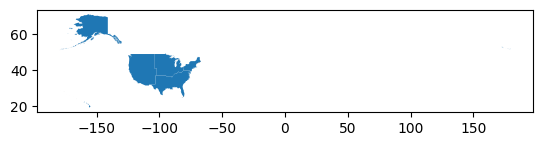

In [24]:
#Plot region shape file
df_region.plot()

<Axes: >

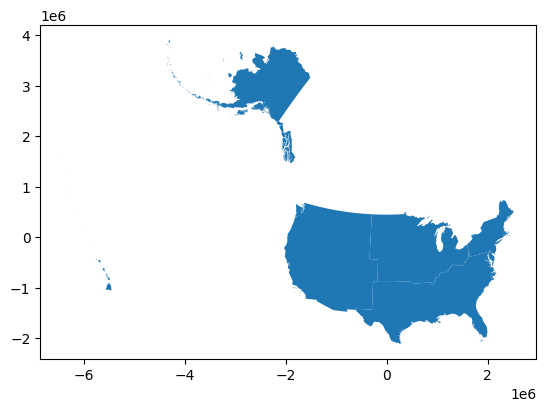

In [25]:
# Converting crs to make plot appear better
df_region = df_region.to_crs("EPSG:9311")
df_region.plot()

In [26]:
#Load state shapefile
state_shape = "cb_2018_us_state_500k.shp"
df_states = gpd.read_file(state_shape)
df_states.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  
0  MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ...  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  
2  POLYGON ((-103.00256 36.52659, -103.00219 36.6...  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...  
4  POLYGON ((-82.6432 38.16909, -82.643 38.16956,...

<Axes: >

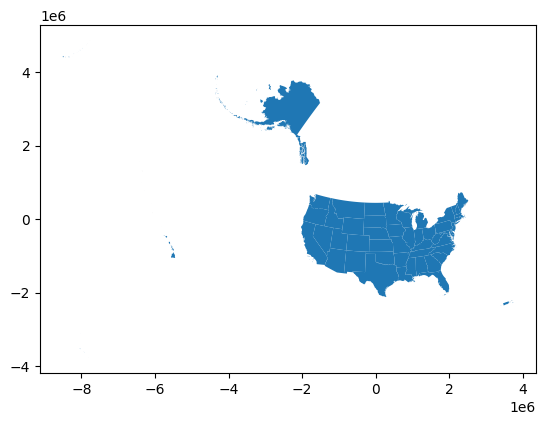

In [27]:
#Convert crs for better visualization and plot
df_states = df_states.to_crs("EPSG:9311")
df_states.plot()

### **2.1.5 Merge df_combined with geospatial state dataset**

In [28]:
df_clean = pd.merge(df_states, df_combined, left_on='NAME', right_on='State Name', how='inner')
df_clean.head()


STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry      State Name  \
0  MULTIPOLYGON (((1109997.773 -1565578.875, 1111...     Mississippi   
1  MULTIPOLYGON (((2154808.027 -692253.992, 21554...  North Carolina   
2  POLYGON ((-268912.756 -936547.904, -268600.891...        Oklahoma   
3  MULTIPOLYGON (((2098153.247 -490400.387, 20981...        Virginia   
4  POLYGON ((1506482.53 -601393.056, 1506489.516 ...   West Virginia   

   Residential Solar Potential (TWh - 2020) Energy Burden Region  
0                                  6.393532         4.57%  South  
1                                 17.992038         3.18%  South  
2                                 10.934683         3.57%  South  
3                                 10.016509         2.98%  South  
4                                  3.404772         3.81%  South

In [29]:
# Check df_clean shape
df_clean.shape

(49, 14)

## **2.2 Analysis**

### **2.2.1. Residential Solar Potential**

**Tasks:**
*   Plot Total Residential Solar Potential by Region
*   Define thresholds for low and high Solar Potential

*  *Total Residential Solar Potential by Region*

In [30]:
#Total solar potential by Region

df_solar_region = df_clean.groupby('Region').agg(
    total_solar=('Residential Solar Potential (TWh - 2020)', 'sum')
).reset_index()

df_solar_region


Region  total_solar
0    Midwest   139.345294
1  Northeast    71.434475
2      South   245.449670
3       West   125.023606

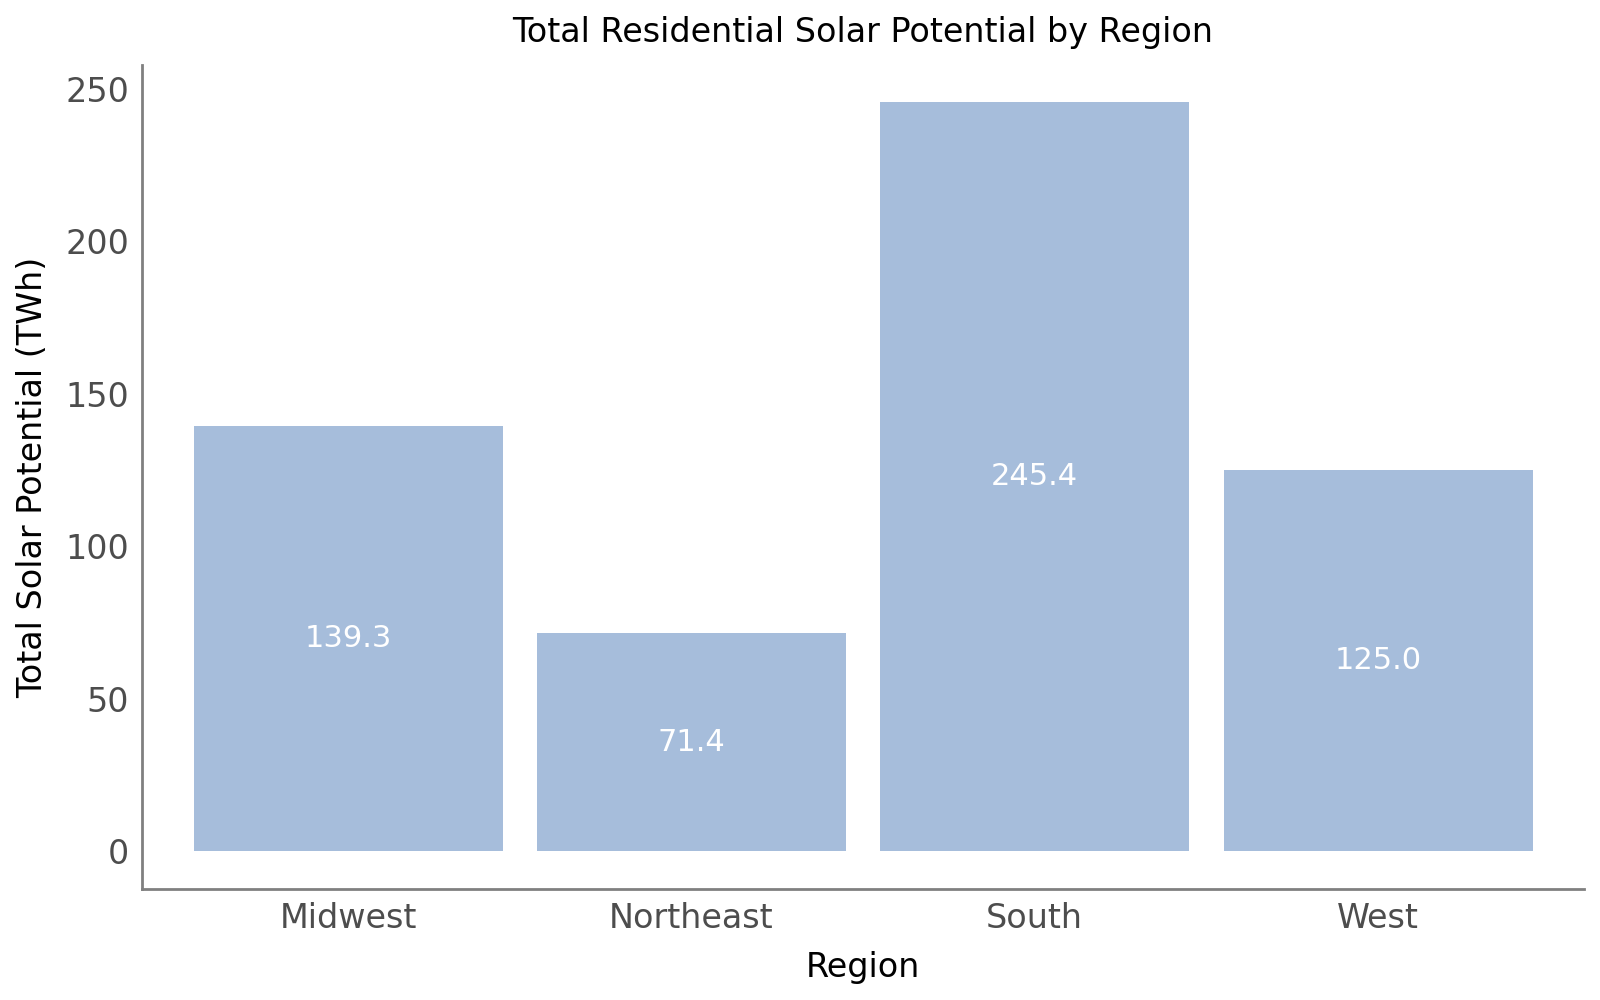

In [31]:
#Plot total residential solar potential
plotnine.options.figure_size = (8, 5)

(
    ggplot(df_solar_region, aes(x='Region', y='total_solar', label='round(total_solar, 1)'))
    + geom_bar(stat='identity', fill='#a6bddb')
    + geom_text(position=position_stack(vjust=0.5), color='white')
    + xlab("Region")
    + ylab("Total Solar Potential (TWh)")
    + ggtitle("Total Residential Solar Potential by Region")
    + theme_classic()
    + theme(
        axis_line=element_line(color="gray"),
        axis_ticks=element_line(color="white"),
        text=element_text(size=12)
    )
)


***This chart shows the total technical potential for residential rooftop solar across U.S. regions. The data source indicates that the technical potential reflects the maximum energy that could be produced if all suitable rooftops had solar panels — based on things like sunlight, roof space, and system efficiency. It doesn’t factor in cost or adoption barriers.***

***We see that the South leads by far, followed by the Midwest and West, while the Northeast trails behind. This likely reflects differences in housing density, sunlight, and rooftop availability.***

In [32]:
#Generate summary statistics for residential solar potential column
df_clean['Residential Solar Potential (TWh - 2020)'].describe()

count    49.000000
mean     11.862307
std      13.909504
min       0.156982
25%       3.542265
50%       8.405122
75%      13.459703
max      70.314636
Name: Residential Solar Potential (TWh - 2020), dtype: float64

<Axes: >

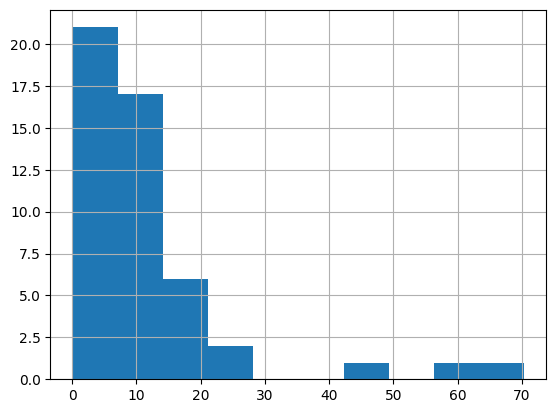

In [33]:
#Plot histogram to examine distribution of residential solar potential
df_clean['Residential Solar Potential (TWh - 2020)'].hist()

***The distribution shows there are some outlier states. We identify those states below and examine why they may have such high solar potential***

In [34]:
# Identify outlier states
outliers = df_clean[df_clean['Residential Solar Potential (TWh - 2020)'] > 40]
outliers


STATEFP   STATENS     AFFGEOID GEOID STUSPS        NAME LSAD         ALAND  \
9       12  00294478  0400000US12    12     FL     Florida   00  138949136250   
14      48  01779801  0400000US48    48     TX       Texas   00  676653171537   
15      06  01779778  0400000US06    06     CA  California   00  403503931312   

         AWATER                                           geometry  \
9   31361101223  MULTIPOLYGON (((1997726.172 -1929592.915, 1997...   
14  19006305260  MULTIPOLYGON (((514197.103 -1677430.313, 51428...   
15  20463871877  MULTIPOLYGON (((-1717282.257 -1090154.595, -17...   

    State Name  Residential Solar Potential (TWh - 2020) Energy Burden Region  
9      Florida                                 45.803021         2.96%  South  
14       Texas                                 61.283431         3.18%  South  
15  California                                 70.314636         2.10%   West

***Florida, Texas and California emerged as the states with the highest potential. To understand why, we assess if land area is a factor***

In [35]:
# Sort by Land Area
df_clean.sort_values(by = 'ALAND',ascending = False).head(3)

STATEFP   STATENS     AFFGEOID GEOID STUSPS        NAME LSAD         ALAND  \
14      48  01779801  0400000US48    48     TX       Texas   00  676653171537   
15      06  01779778  0400000US06    06     CA  California   00  403503931312   
29      30  00767982  0400000US30    30     MT     Montana   00  376962738765   

         AWATER                                           geometry  \
14  19006305260  MULTIPOLYGON (((514197.103 -1677430.313, 51428...   
15  20463871877  MULTIPOLYGON (((-1717282.257 -1090154.595, -17...   
29   3869208832  POLYGON ((-1172889.072 508069.731, -1172583.63...   

    State Name  Residential Solar Potential (TWh - 2020) Energy Burden Region  
14       Texas                                 61.283431         3.18%  South  
15  California                                 70.314636         2.10%   West  
29     Montana                                  1.552311         4.21%   West

In [36]:
# Normalize the solar potential column by land area

df_clean['Land Area (sq mi)'] = df_clean['ALAND'] / 2.59e+6  # Convert from square meters to square miles
df_clean['Solar_per_sq_mile'] = df_clean['Residential Solar Potential (TWh - 2020)'] / df_clean['Land Area (sq mi)']

df_clean.head(2)

STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   

                                            geometry      State Name  \
0  MULTIPOLYGON (((1109997.773 -1565578.875, 1111...     Mississippi   
1  MULTIPOLYGON (((2154808.027 -692253.992, 21554...  North Carolina   

   Residential Solar Potential (TWh - 2020) Energy Burden Region  \
0                                  6.393532         4.57%  South   
1                                 17.992038         3.18%  South   

   Land Area (sq mi)  Solar_per_sq_mile  
0       46924.138796           0.000136  
1       48619.172225           0.000370

<Axes: >

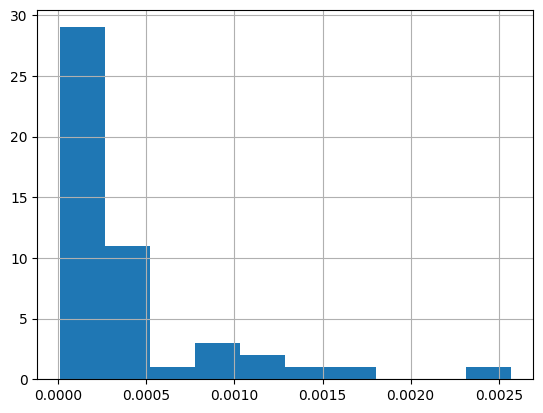

In [37]:
# Plot the histogram of normalized solar potential
df_clean['Solar_per_sq_mile'].hist()

In [38]:
# Identify outliers
df_clean[df_clean['Solar_per_sq_mile'] > 0.0020]

STATEFP   STATENS     AFFGEOID GEOID STUSPS                  NAME LSAD  \
34      11  01702382  0400000US11    11     DC  District of Columbia   00   

        ALAND    AWATER                                           geometry  \
34  158340391  18687198  POLYGON ((1950799.304 -402452.215, 1951231.574...   

              State Name  Residential Solar Potential (TWh - 2020)  \
34  District of Columbia                                  0.156982   

   Energy Burden Region  Land Area (sq mi)  Solar_per_sq_mile  
34         2.11%  South          61.135286           0.002568

***D.C. appears as an outlier when solar potential is normalized by land area because it has very limited land but relatively high solar potential packed into that space. Its small size makes the potential per square mile unusually high.***

**In contrast, Texas, California, and Florida were outliers in terms of total solar potential. Texas and California are the 2nd and 3rd largest states by land area, while Florida, though smaller, has a large residential footprint and consistently high solar exposure. While they fall into different Census regions — South (Texas, Florida) and West (California) — they all sit in sun-rich parts of the country, which helps explain their high overall potential.**

*   *Define Threshold*

***To classify states by solar potential, we examined the distribution of residential solar generation data across 49 states. The histogram revealed a right-skewed distribution, with most states having relatively low solar potential and only a few states showing very high values. While the average potential was around 11.9 TWh, the 75th percentile (13.5 TWh) offered a more meaningful threshold to identify states with “high” solar potential, avoiding the distortion caused by outliers. We therefore defined high solar potential as any state above this 75th percentile cutoff.***

In [39]:
#Clasify states by solar potential using the 75th percentile as a threshold for classification
solar_threshold = df_clean['Residential Solar Potential (TWh - 2020)'].quantile(0.75)

df_clean['Solar Potential Class'] = np.where(
    df_clean['Residential Solar Potential (TWh - 2020)'] <= solar_threshold,
    'Low Potential',
    'High Potential')

df_clean.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry      State Name  \
0  MULTIPOLYGON (((1109997.773 -1565578.875, 1111...     Mississippi   
1  MULTIPOLYGON (((2154808.027 -692253.992, 21554...  North Carolina   
2  POLYGON ((-268912.756 -936547.904, -268600.891...        Oklahoma   
3  MULTIPOLYGON (((2098153.247 -490400.387, 20981...        Virginia   
4  POLYGON ((1506482.53 -601393.056, 1506489.516 ...   West Virginia   

   Residential Solar Potential (TWh - 2020) Energy Burden Region  \
0                                  6.393532         4.57%  South   
1                                 17.992038         3.18%  South   
2                                 10.934683         3.57%  South   
3                                 10.016509         2.98%  South   
4                                  3.404772         3.81%  South   

   Land Area (sq mi)  Solar_per_sq_mile Solar Potential Class  
0       46924.138796           0.000136         Low Potential  
1       48619.172225           0.000370        High Potential  
2       68595.724217           0.000159         Low Potential  
3       39481.744058           0.000254         Low Potential  
4       24041.109851           0.000142         Low Potential

###**2.2.2 Energy Burden**


*  Plot Average Energy Burden by Region
*  Define thresholds for low and high Energy Burdens








*   *Average Energy Burden by Region*




In [40]:
# Remove the percent sign and convert to float
df_clean['Energy Burden'] = df_clean['Energy Burden'].str.rstrip('%').astype(float)

#Average energy burden by region
df_burden_region = df_clean.groupby('Region').agg(
    average_burden=('Energy Burden', 'mean')
).reset_index()

df_burden_region


Region  average_burden
0    Midwest        3.503333
1  Northeast        4.017778
2      South        3.504118
3       West        2.770909

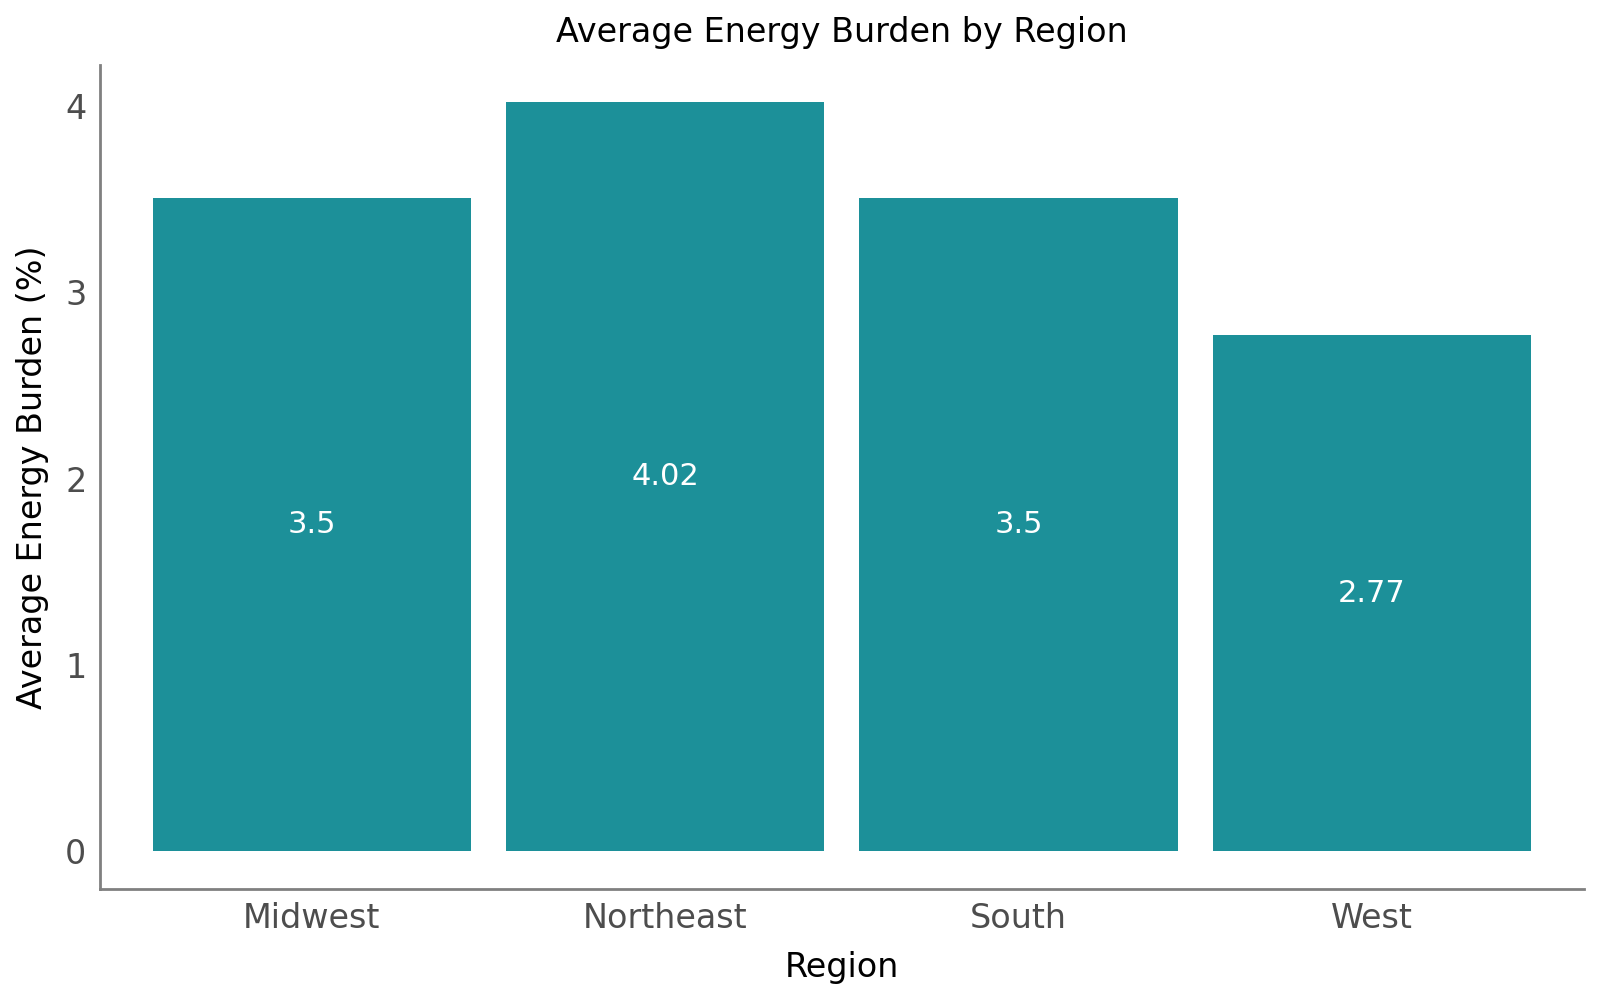

In [41]:
#Plot average energy burden
plotnine.options.figure_size = (8, 5)

(
    ggplot(df_burden_region, aes(x='Region', y='average_burden', label='round(average_burden, 2)'))
    + geom_bar(stat='identity', fill='#1c9099')
    + geom_text(position=position_stack(vjust=0.5), color='white')
    + xlab("Region")
    + ylab("Average Energy Burden (%)")
    + ggtitle("Average Energy Burden by Region")
    + theme_classic()
    + theme(
        axis_line=element_line(color="gray"),
        axis_ticks=element_line(color="white"),
        text=element_text(size=12)
    )
)

***Energy burden appears relatively consistent across most regions, though the Northeast stands out with a slightly higher average, while the West has the lowest burden overall***

*  *Define Threshold*

***Energy burden is generally considered high when energy expenditures account for 6% of household income. Energy burden is severe when 10% or more is allocated to energy costs. https://www.aceee.org/research-report/u2006***



In [42]:
#check data
df_clean['Energy Burden'].describe()

count    49.000000
mean      3.433673
std       0.765282
min       2.100000
25%       2.970000
50%       3.450000
75%       3.820000
max       5.420000
Name: Energy Burden, dtype: float64

<Axes: >

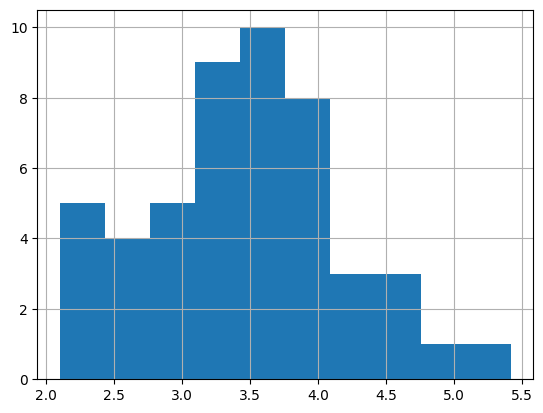

In [43]:
#plot energy burden column data
df_clean['Energy Burden'].hist()

***Since none of the states in our dataset exceeded the cited 6% threshold for high energy burden, we used the median state-level burden of 3.45% as our dividing line. This allows us to compare states with relatively higher or lower energy burdens across the country, even if none meet the extreme definition of energy poverty. This relative threshold helps us identify where burden and solar potential intersect most meaningfully.***

In [44]:
#Set burden threshold using the median state level and classify based on value
burden_threshold = df_clean['Energy Burden'].mean()

df_clean['Energy Burden Class'] = np.where(
    df_clean['Energy Burden'] <= burden_threshold,
    'Low Burden',
    'High Burden')


df_clean.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry      State Name  \
0  MULTIPOLYGON (((1109997.773 -1565578.875, 1111...     Mississippi   
1  MULTIPOLYGON (((2154808.027 -692253.992, 21554...  North Carolina   
2  POLYGON ((-268912.756 -936547.904, -268600.891...        Oklahoma   
3  MULTIPOLYGON (((2098153.247 -490400.387, 20981...        Virginia   
4  POLYGON ((1506482.53 -601393.056, 1506489.516 ...   West Virginia   

   Residential Solar Potential (TWh - 2020)  Energy Burden Region  \
0                                  6.393532           4.57  South   
1                                 17.992038           3.18  South   
2                                 10.934683           3.57  South   
3                                 10.016509           2.98  South   
4                                  3.404772           3.81  South   

   Land Area (sq mi)  Solar_per_sq_mile Solar Potential Class  \
0       46924.138796           0.000136         Low Potential   
1       48619.172225           0.000370        High Potential   
2       68595.724217           0.000159         Low Potential   
3       39481.744058           0.000254         Low Potential   
4       24041.109851           0.000142         Low Potential   

  Energy Burden Class  
0         High Burden  
1          Low Burden  
2         High Burden  
3          Low Burden  
4         High Burden

In [45]:
#Label Quadrants
df_clean['Quadrant'] = df_clean['Solar Potential Class'] + ' / ' + df_clean['Energy Burden Class']
df_clean.head()


STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry      State Name  \
0  MULTIPOLYGON (((1109997.773 -1565578.875, 1111...     Mississippi   
1  MULTIPOLYGON (((2154808.027 -692253.992, 21554...  North Carolina   
2  POLYGON ((-268912.756 -936547.904, -268600.891...        Oklahoma   
3  MULTIPOLYGON (((2098153.247 -490400.387, 20981...        Virginia   
4  POLYGON ((1506482.53 -601393.056, 1506489.516 ...   West Virginia   

   Residential Solar Potential (TWh - 2020)  Energy Burden Region  \
0                                  6.393532           4.57  South   
1                                 17.992038           3.18  South   
2                                 10.934683           3.57  South   
3                                 10.016509           2.98  South   
4                                  3.404772           3.81  South   

   Land Area (sq mi)  Solar_per_sq_mile Solar Potential Class  \
0       46924.138796           0.000136         Low Potential   
1       48619.172225           0.000370        High Potential   
2       68595.724217           0.000159         Low Potential   
3       39481.744058           0.000254         Low Potential   
4       24041.109851           0.000142         Low Potential   

  Energy Burden Class                     Quadrant  
0         High Burden  Low Potential / High Burden  
1          Low Burden  High Potential / Low Burden  
2         High Burden  Low Potential / High Burden  
3          Low Burden   Low Potential / Low Burden  
4         High Burden  Low Potential / High Burden

In [46]:
#Check Unique values
df_clean.Quadrant.unique()

array(['Low Potential / High Burden', 'High Potential / Low Burden',
       'Low Potential / Low Burden', 'High Potential / High Burden'],
      dtype=object)

##**2.3.Plots**

*   Scatterplot of Energy Burden and Residential Solar Potential Quadrants

*   Visualization of Energy Burden and Residential Solar Potential Quadrants on State Map
*   List of High Potential/ High Burden States



### **2.3.1 Scatterplot**

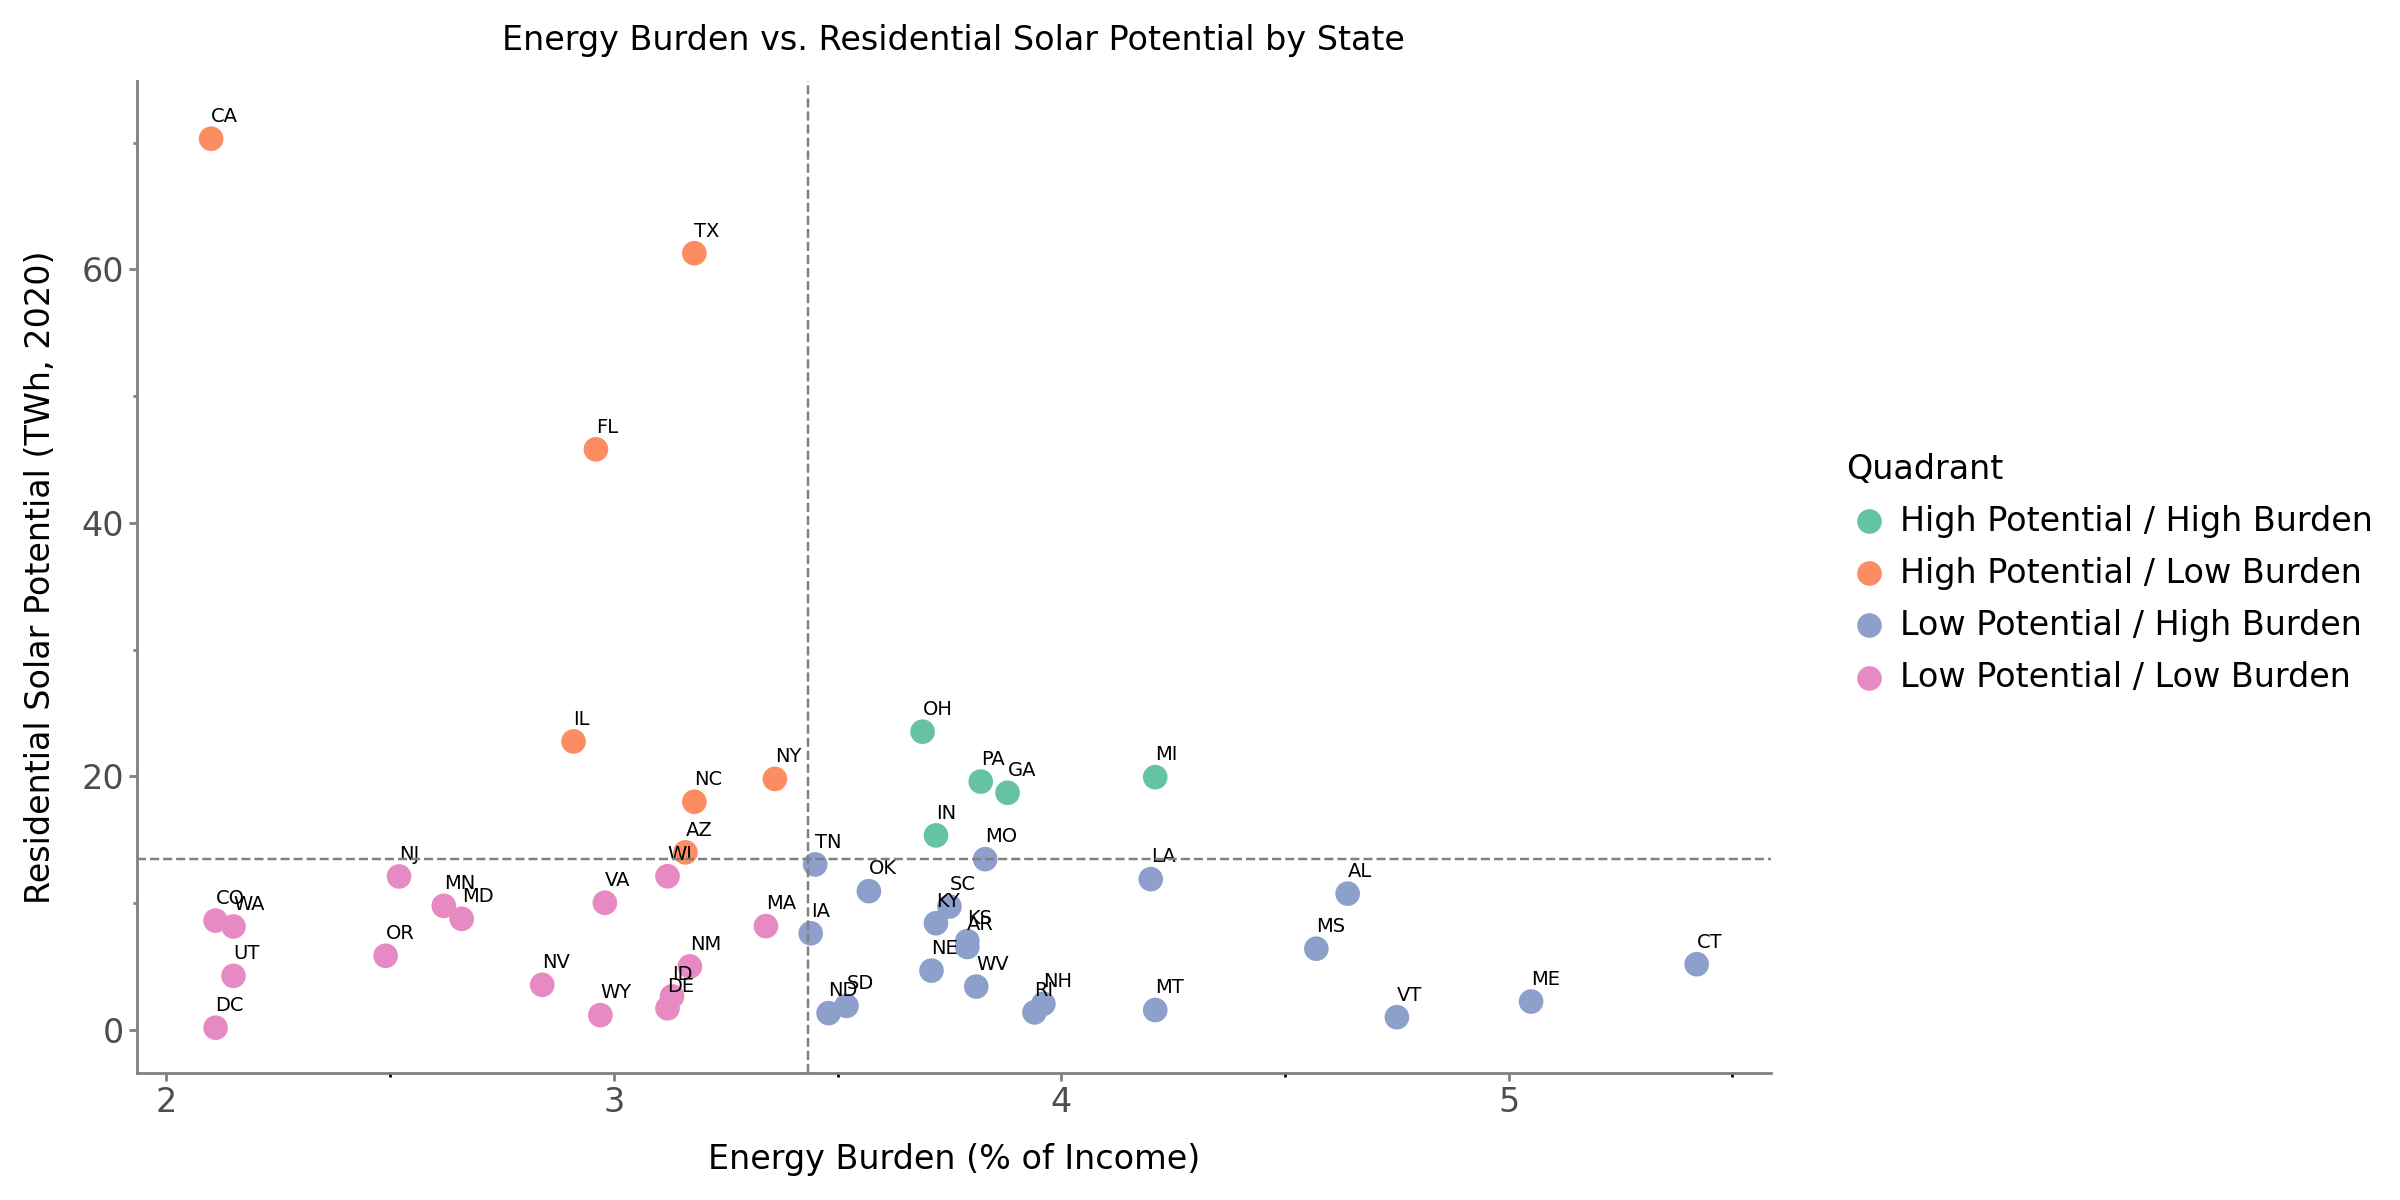

In [47]:
#Create a scatterplot to visualize the classification

plotnine.options.figure_size = (12, 6)

(
    ggplot(df_clean)
    + geom_point(
        aes(
            x='Energy Burden',
            y='Residential Solar Potential (TWh - 2020)',
            color='Quadrant'
        ),
        size=4
    )
    + geom_text(
    aes(
        x='Energy Burden',
        y='Residential Solar Potential (TWh - 2020)',
        label='STUSPS'
    ),
    size=7,
    va='bottom',
    ha='left',
    nudge_y=1,
    color='black'
)
    + geom_vline(xintercept = burden_threshold, linetype='dashed', color='gray')
    + geom_hline(yintercept = solar_threshold, linetype='dashed', color='gray')
    + xlab("Energy Burden (% of Income)")
    + ylab("Residential Solar Potential (TWh, 2020)")
    + labs(color='Quadrant')  # Legend title
    + ggtitle("Energy Burden vs. Residential Solar Potential by State")
    + theme_classic()
    + theme(
        axis_line=element_line(color="gray"),
        axis_ticks=element_line(color="gray"),
        text=element_text(size=12),
        legend_position="right"
    )
    + scale_color_brewer(type="qual", palette="Set2")
)


In [48]:
# Value Counts of State per Quadrant
df_clean['Quadrant'].value_counts()

Quadrant
Low Potential / High Burden     21
Low Potential / Low Burden      16
High Potential / Low Burden      7
High Potential / High Burden     5
Name: count, dtype: int64

***The scatterplot shows a strong separation of states across the four quadrants. It’s not surprising to see California, Texas, and Florida standing out with high solar potential but relatively lower energy burdens — these states have large populations, and abundant sunlight, but also generally higher average incomes that keep energy burdens manageable.***


### **2.3.2 US State Map**

In [49]:
# Calculating centroids for map labels

df_clean['x'] = df_clean.geometry.centroid.x
df_clean['y'] = df_clean.geometry.centroid.y
df_clean.head(2)

STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   

                                            geometry  ...  \
0  MULTIPOLYGON (((1109997.773 -1565578.875, 1111...  ...   
1  MULTIPOLYGON (((2154808.027 -692253.992, 21554...  ...   

  Residential Solar Potential (TWh - 2020)  Energy Burden  Region  \
0                                 6.393532           4.57   South   
1                                17.992038           3.18   South   

  Land Area (sq mi)  Solar_per_sq_mile  Solar Potential Class  \
0      46924.138796           0.000136          Low Potential   
1      48619.172225           0.000370         High Potential   

  Energy Burden Class                     Quadrant             x             y  
0         High Burden  Low Potential / High Burden  9.689095e+05 -1.302366e+06  
1          Low Burden  High Potential / Low Burden  1.849252e+06 -8.207198e+05  

[2 rows x 21 columns]

In [50]:
#check data
df_clean.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype   
---  ------                                    --------------  -----   
 0   STATEFP                                   49 non-null     object  
 1   STATENS                                   49 non-null     object  
 2   AFFGEOID                                  49 non-null     object  
 3   GEOID                                     49 non-null     object  
 4   STUSPS                                    49 non-null     object  
 5   NAME                                      49 non-null     object  
 6   LSAD                                      49 non-null     object  
 7   ALAND                                     49 non-null     int64   
 8   AWATER                                    49 non-null     int64   
 9   geometry                                  49 non-null     geometry
 10  State Name          

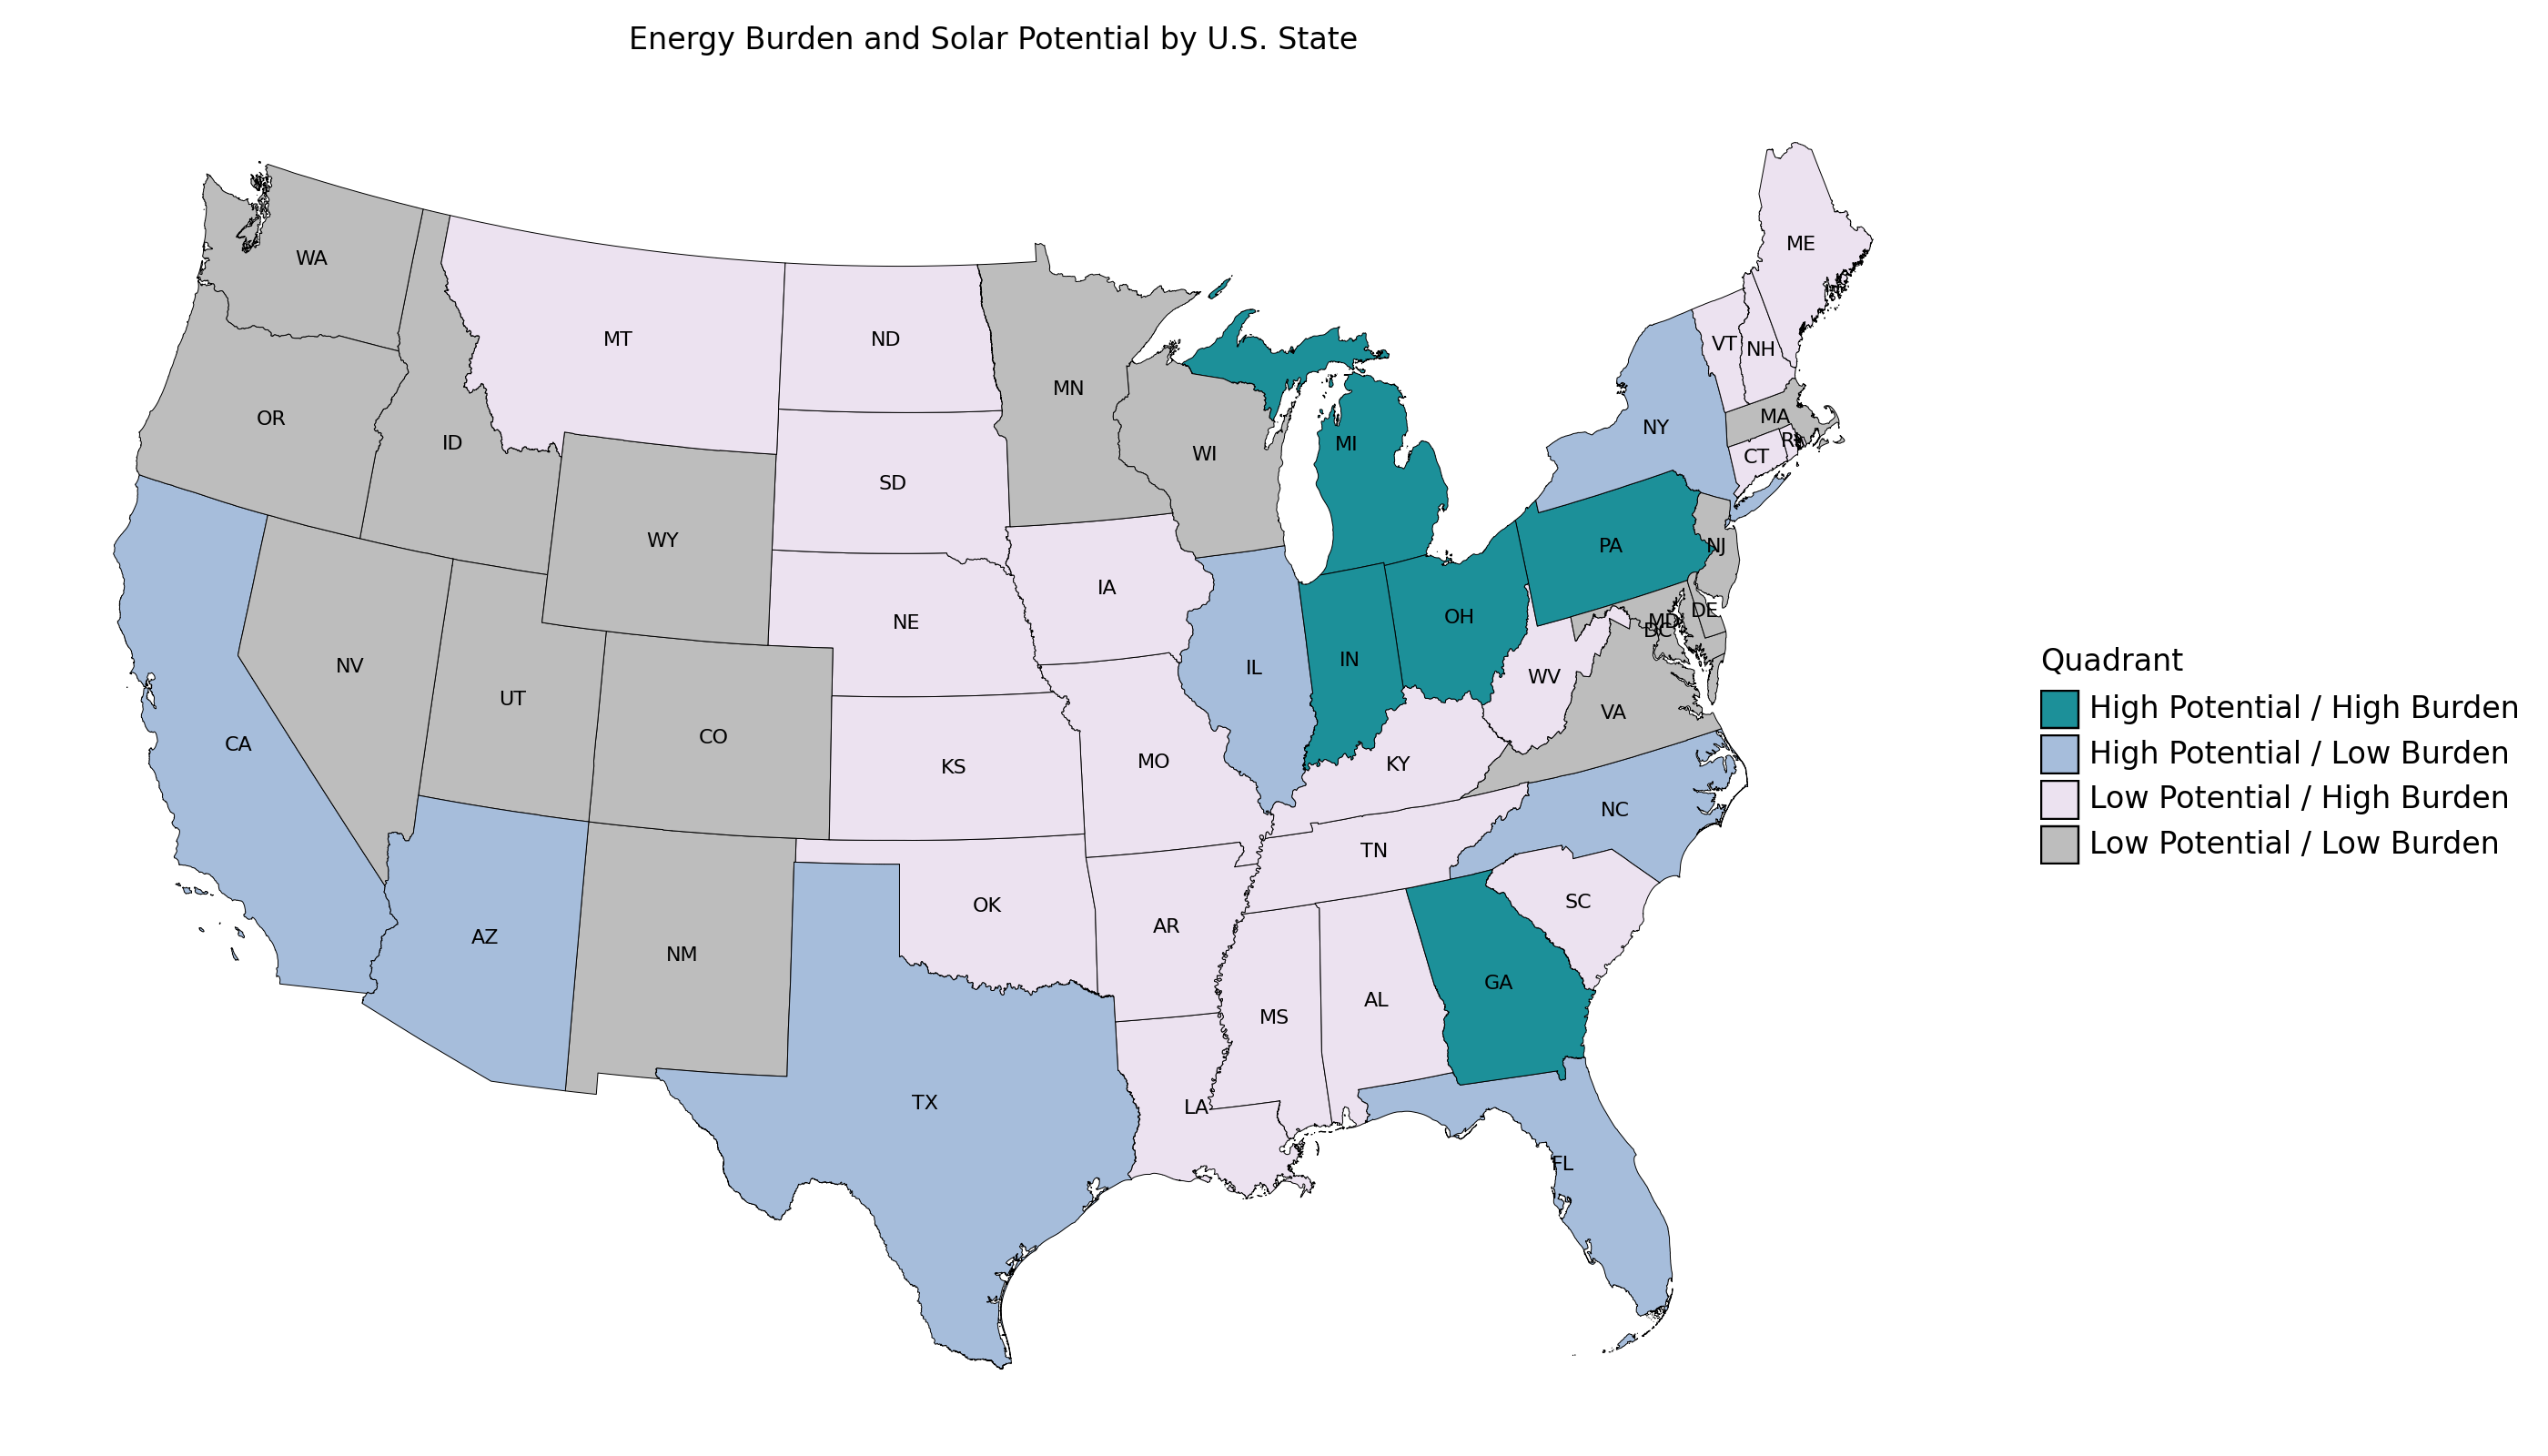

In [51]:
#plot
plotnine.options.figure_size = (14, 8)

(
    ggplot(df_clean)
    + geom_map(aes(fill='Quadrant'), color='black', size=0.2)
    + geom_text(aes(x='x', y='y', label='STUSPS'), size=8, color='black')
    + scale_fill_manual(
        name="Quadrant",
        values={
            "High Potential / High Burden": "#1c9099",
            "High Potential / Low Burden": "#a6bddb",
            "Low Potential / High Burden": "#ece2f0",
            "Low Potential / Low Burden": "#bdbdbd"
        }
    )
    + ggtitle("Energy Burden and Solar Potential by U.S. State")
    + theme_classic()
    + theme(
        axis_text=element_blank(),
        axis_ticks=element_blank(),
        axis_line = element_line(color="white"),
        text=element_text(size=12),
        legend_title=element_text(size=12),
        legend_position='right'
    )
    + xlab("")
    + ylab("")
)


### **2.2.3 List of High Potential/ High Burden States**

In [52]:
# States with high energy burden and residential solar potential
df_clean[df_clean.Quadrant == "High Potential / High Burden"][['NAME', 'Region', 'Residential Solar Potential (TWh - 2020)',
                                                               'Energy Burden']]

NAME     Region  Residential Solar Potential (TWh - 2020)  \
6       Michigan    Midwest                                 19.931620   
17       Georgia      South                                 18.698911   
18  Pennsylvania  Northeast                                 19.582856   
41          Ohio    Midwest                                 23.521982   
46       Indiana    Midwest                                 15.332584   

    Energy Burden  
6            4.21  
17           3.88  
18           3.82  
41           3.69  
46           3.72

*   **Clear Regional Patterns exist**:
  *   **Southern** and **Midwestern** states mostly fall into the Low Potential / High Burden quadrant, meaning households face higher energy costs but have fewer rooftop solar opportunities.
  *   **Western** states like California, Arizona, and Texas land in the High Potential / Low Burden quadrant, benefiting from strong solar resources and generally lower energy burdens.
  *  **Five key states** — Ohio, Pennsylvania, Indiana, Michigan, and Georgia — emerge in the High Potential / High Burden quadrant, signaling priority opportunities for solar programs where technical potential is high but affordability remains a challenge.

<br>

*   **Opportunity is not confined to one region:**
  *  The **Midwest (Michigan, Ohio, and Indiana)** shows that even with decent sunlight for solar, many people still face high energy costs — often because homes are older, less efficient, and more expensive to heat and cool.
  *  The **South (Georgia)** proves that just having significant sunshine is not enough. Many families still deal with high energy burdens due to income gaps, older housing, and utility structures that make energy less affordable.
  *  The **Northeast (Pennsylvania)** is interesting because, even though the region does not get as much sun overall, states like Pennsylvania have stronger rooftop solar potential than expected, likley due to the large stock of single-family homes and supportive state programs.Energy burden may also be worsened by the colder winters seen in the region.

  <br>
  <br>

# **3. COUNTY-LEVEL ANALYSIS**

After identifying states with both high energy burden and high solar potential through national-level quadrant mapping, the next phase of the project zooms in to examine disparities within these selected states at the county level.

The goal of the county-level analysis is to deepen understanding of how energy burden, rooftop solar potential, and socio-economics/ demographics align geographically. Specifically, this step identifies priority counties where the need for affordable clean energy solutions is most urgent — and where interventions can most effectively target both opportunity and inequity.

<br>

To do this:

1.   Counties within the selected states are analyzed based on:
*   **Energy Burden** (share of household income spent on energy costs)
*   **Solar Potential** (technical feasibility of rooftop solar adoption)
*   Socioeconomic and demographic indicators:
  *  **Black, Indigenous and People of Color (BIPOC) Population**: Captures racial and ethnic equity dimensions, as communities of color often face higher energy burdens and barriers to clean energy access.
  *  **Per Capita Income**: Provides a measure of overall economic status within a county.
  *  **Poverty Rate**: ocuses specifically on the proportion of residents living below the poverty line, providing a sharper lens on deeper economic hardship that might not be captured by average income alone.


2. A **K-means clustering analysis** groups counties into distinct categories based on similarities across these metrics, offering a more nuanced framework than simple thresholding.

3. **Spatial autocorrelation analysis (Moran’s I)** is also used to assess whether counties with high energy burden or high solar potential tend to cluster geographically, informing future place-based policy design.


## **3.1. Prepare Data**

### **3.1.1 Upload and Clean Solar Potential Dataset**

The data represents a projection of possible Solar PV generation for 2020 based on 2012 -2018 data. It was obtained from the National Renewable Energy Laboratory at *https://maps.nrel.gov/slope/data-viewer?filters=%5B%5D&layer=energy-generation.residential-pv&year=2020&res=county&energyBurdenPcnt=0.06&transportationBurdenPcnt=0.04&sviTheme=mn&sviPcntl=0*

In [53]:
# Upload Dataset
solarpot_county = pd.read_csv('https://raw.githubusercontent.com/envirodatascience/final-project-solar-team/refs/heads/main/techpot_baseline_county.csv')
solarpot_county.head()


County Name State Name State Geography ID       Technology Geography ID  \
0     Autauga    Alabama                G01       utility_pv     G0100010   
1     Autauga    Alabama                G01  land_based_wind     G0100010   
2     Autauga    Alabama                G01              csp     G0100010   
3     Autauga    Alabama                G01   residential_pv     G0100010   
4     Autauga    Alabama                G01    commercial_pv     G0100010   

   Technical Generation Potential - MWh MWh  
0                               35852218.05  
1                                3474215.08  
2                                8860772.94  
3                                 122752.69  
4                                  72863.02

In [54]:
# Explore Dataset
solarpot_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18477 entries, 0 to 18476
Data columns (total 6 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   County Name                               18477 non-null  object 
 1   State Name                                18477 non-null  object 
 2   State Geography ID                        18477 non-null  object 
 3   Technology                                18477 non-null  object 
 4   Geography ID                              18477 non-null  object 
 5   Technical Generation Potential - MWh MWh  18477 non-null  float64
dtypes: float64(1), object(5)
memory usage: 866.2+ KB


In [55]:
# Check for non-standard missing values (e.g 999) in tech potential column
solarpot_county['Technical Generation Potential - MWh MWh'].describe()

count    1.847700e+04
mean     2.400910e+07
std      8.318026e+07
min      0.000000e+00
25%      5.669595e+04
50%      1.877751e+06
75%      1.081858e+07
max      2.221588e+09
Name: Technical Generation Potential - MWh MWh, dtype: float64

***There are no placeholder values in the column***

In [56]:
# Convert Tech potential column to Terawatt-hours for easier readability
solarpot_county['Technical Generation Potential – TWh'] = solarpot_county['Technical Generation Potential - MWh MWh'] / 1e6
solarpot_county.head()

County Name State Name State Geography ID       Technology Geography ID  \
0     Autauga    Alabama                G01       utility_pv     G0100010   
1     Autauga    Alabama                G01  land_based_wind     G0100010   
2     Autauga    Alabama                G01              csp     G0100010   
3     Autauga    Alabama                G01   residential_pv     G0100010   
4     Autauga    Alabama                G01    commercial_pv     G0100010   

   Technical Generation Potential - MWh MWh  \
0                               35852218.05   
1                                3474215.08   
2                                8860772.94   
3                                 122752.69   
4                                  72863.02   

   Technical Generation Potential – TWh  
0                             35.852218  
1                              3.474215  
2                              8.860773  
3                              0.122753  
4                              0.072863

In [57]:
#Pivot data so each technology type becomes its own column for easy merging
solarpot_county_pivot = solarpot_county.pivot( index=['State Name', 'County Name', 'Geography ID'],columns='Technology',values='Technical Generation Potential – TWh').reset_index()
solarpot_county_pivot.head()

Technology State Name County Name Geography ID  commercial_pv        csp  \
0             Alabama     Autauga     G0100010       0.072863   8.860773   
1             Alabama     Baldwin     G0100030       0.361886  27.316167   
2             Alabama     Barbour     G0100050       0.088222   4.389221   
3             Alabama        Bibb     G0100070       0.064287   0.000000   
4             Alabama      Blount     G0100090       0.290436   0.000000   

Technology  distributed_wind  land_based_wind  residential_pv  utility_pv  
0                   4.806265         3.474215        0.122753   35.852218  
1                  12.261782         1.999889        0.483009  125.782205  
2                   5.817285         5.579908        0.042824   66.148275  
3                   4.436064         4.653853        0.037918   19.269090  
4                   7.151346         3.077282        0.122025   22.617018

### **3.1.2 Upload and Clean Energy Burden Dataset**

The data was obtained from the National Renewable Energy Laboratory at *https://maps.nrel.gov/slope/data-viewer?filters=%5B%5D&layer=eej.household-energy-burden&year=2020&res=county*

In [58]:
burden_county = pd.read_csv('https://raw.githubusercontent.com/envirodatascience/final-project-solar-team/refs/heads/main/household_energy_burden_baseline_county.csv')
burden_county.head()

County Name   State Name State Geography ID Geography ID  \
0   Roosevelt   New Mexico                G35     G3500410   
1       Scott  Mississippi                G28     G2801230   
2   St. Clair     Illinois                G17     G1701630   
3  Washington     Illinois                G17     G1701890   
4      Marion     Arkansas                G05     G0500890   

   Transportation Burden Pct Income  Energy Burden Pct Income  
0                          0.042145                    0.0387  
1                          0.043795                    0.0489  
2                          0.034521                    0.0306  
3                          0.042373                    0.0467  
4                          0.040075                    0.0508

In [59]:
# Explore Dataset
burden_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3219 entries, 0 to 3218
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   County Name                       3219 non-null   object 
 1   State Name                        3219 non-null   object 
 2   State Geography ID                3219 non-null   object 
 3   Geography ID                      3219 non-null   object 
 4   Transportation Burden Pct Income  3139 non-null   float64
 5   Energy Burden Pct Income          3219 non-null   float64
dtypes: float64(2), object(4)
memory usage: 151.0+ KB


In [60]:
# Check for non-standard missing values (e.g 999) in energy burden %income column
burden_county['Energy Burden Pct Income'].describe()

count    3219.000000
mean        0.040462
std         0.013181
min         0.008700
25%         0.031600
50%         0.039600
75%         0.047900
max         0.130000
Name: Energy Burden Pct Income, dtype: float64

***There are no placeholder values in the column***

In [61]:
# Convert Pct Income columns from decimals to percentages
burden_county['Transportation Burden'] = round(burden_county['Transportation Burden Pct Income'] * 100, 2)
burden_county['Energy Burden'] = round(burden_county['Energy Burden Pct Income'] * 100, 2)

# Format New columns as percentages
burden_county['Transportation Burden'] = burden_county['Transportation Burden'].apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else "")
burden_county['Energy Burden'] = burden_county['Energy Burden'].apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else "")

burden_county.head()

County Name   State Name State Geography ID Geography ID  \
0   Roosevelt   New Mexico                G35     G3500410   
1       Scott  Mississippi                G28     G2801230   
2   St. Clair     Illinois                G17     G1701630   
3  Washington     Illinois                G17     G1701890   
4      Marion     Arkansas                G05     G0500890   

   Transportation Burden Pct Income  Energy Burden Pct Income  \
0                          0.042145                    0.0387   
1                          0.043795                    0.0489   
2                          0.034521                    0.0306   
3                          0.042373                    0.0467   
4                          0.040075                    0.0508   

  Transportation Burden Energy Burden  
0                 4.21%         3.87%  
1                 4.38%         4.89%  
2                 3.45%         3.06%  
3                 4.24%         4.67%  
4                 4.01%         5.08%

### **3.1.3 Upload and Clean Demographics Data**


The data was obtained from *https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data?resource=download* based on the DP03 and DP05 tables of the 2015 American Community Survey 5-year estimates.

In [62]:
# Upload Dataset

demographics = pd.read_csv('https://raw.githubusercontent.com/envirodatascience/final-project-solar-team/refs/heads/main/acs2017_county_data.csv')
demographics.head()

CountyId    State          County  TotalPop    Men   Women  Hispanic  \
0      1001  Alabama  Autauga County     55036  26899   28137       2.7   
1      1003  Alabama  Baldwin County    203360  99527  103833       4.4   
2      1005  Alabama  Barbour County     26201  13976   12225       4.2   
3      1007  Alabama     Bibb County     22580  12251   10329       2.4   
4      1009  Alabama   Blount County     57667  28490   29177       9.0   

   White  Black  Native  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  \
0   75.4   18.9     0.3  ...   0.6          1.3         2.5         25.8   
1   83.1    9.5     0.8  ...   0.8          1.1         5.6         27.0   
2   45.7   47.8     0.2  ...   2.2          1.7         1.3         23.4   
3   74.6   22.0     0.4  ...   0.3          1.7         1.5         30.0   
4   87.4    1.5     0.3  ...   0.4          0.4         2.1         35.0   

   Employed  PrivateWork  PublicWork  SelfEmployed  FamilyWork  Unemployment  
0     24112         74.1        20.2           5.6         0.1           5.2  
1     89527         80.7        12.9           6.3         0.1           5.5  
2      8878         74.1        19.1           6.5         0.3          12.4  
3      8171         76.0        17.4           6.3         0.3           8.2  
4     21380         83.9        11.9           4.0         0.1           4.9  

[5 rows x 37 columns]

In [63]:
# Explore Dataset
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CountyId          3220 non-null   int64  
 1   State             3220 non-null   object 
 2   County            3220 non-null   object 
 3   TotalPop          3220 non-null   int64  
 4   Men               3220 non-null   int64  
 5   Women             3220 non-null   int64  
 6   Hispanic          3220 non-null   float64
 7   White             3220 non-null   float64
 8   Black             3220 non-null   float64
 9   Native            3220 non-null   float64
 10  Asian             3220 non-null   float64
 11  Pacific           3220 non-null   float64
 12  VotingAgeCitizen  3220 non-null   int64  
 13  Income            3220 non-null   int64  
 14  IncomeErr         3220 non-null   int64  
 15  IncomePerCap      3220 non-null   int64  
 16  IncomePerCapErr   3220 non-null   int64  


In [64]:
# Check for duplicates
demographics[demographics[['State','County']].duplicated()]

Empty DataFrame
Columns: [CountyId, State, County, TotalPop, Men, Women, Hispanic, White, Black, Native, Asian, Pacific, VotingAgeCitizen, Income, IncomeErr, IncomePerCap, IncomePerCapErr, Poverty, ChildPoverty, Professional, Service, Office, Construction, Production, Drive, Carpool, Transit, Walk, OtherTransp, WorkAtHome, MeanCommute, Employed, PrivateWork, PublicWork, SelfEmployed, FamilyWork, Unemployment]
Index: []

[0 rows x 37 columns]

In [65]:
# Remove the suffices from the county names for easy merging with other datasets
suffixes = [' County',' Parish', ' Borough']
pattern = r'\b(?:' + '|'.join(suffixes) + r')\b'
demographics['County'] = demographics['County'].str.replace(pattern, '', regex=True)

demographics.head()

CountyId    State   County  TotalPop    Men   Women  Hispanic  White  \
0      1001  Alabama  Autauga     55036  26899   28137       2.7   75.4   
1      1003  Alabama  Baldwin    203360  99527  103833       4.4   83.1   
2      1005  Alabama  Barbour     26201  13976   12225       4.2   45.7   
3      1007  Alabama     Bibb     22580  12251   10329       2.4   74.6   
4      1009  Alabama   Blount     57667  28490   29177       9.0   87.4   

   Black  Native  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
0   18.9     0.3  ...   0.6          1.3         2.5         25.8     24112   
1    9.5     0.8  ...   0.8          1.1         5.6         27.0     89527   
2   47.8     0.2  ...   2.2          1.7         1.3         23.4      8878   
3   22.0     0.4  ...   0.3          1.7         1.5         30.0      8171   
4    1.5     0.3  ...   0.4          0.4         2.1         35.0     21380   

   PrivateWork  PublicWork  SelfEmployed  FamilyWork  Unemployment  
0         74.1        20.2           5.6         0.1           5.2  
1         80.7        12.9           6.3         0.1           5.5  
2         74.1        19.1           6.5         0.3          12.4  
3         76.0        17.4           6.3         0.3           8.2  
4         83.9        11.9           4.0         0.1           4.9  

[5 rows x 37 columns]

### **3.1.4 Merge Solar Potential, Energy Burden and Demographics Datasets**

In [66]:
# States with High Potential/High Burden from Race dataframe
selected_states = ["Michigan", "Georgia", "Pennsylvania", "Ohio", "Indiana"]

# Filter selected states out from each dataset
solarpot_county_filtered = solarpot_county_pivot[solarpot_county_pivot['State Name'].isin(selected_states)]
burden_county_filtered = burden_county[burden_county['State Name'].isin(selected_states)]
demographics_filtered = demographics[demographics['State'].isin(selected_states)]

In [67]:
# Check filtered dataset for solar potential
solarpot_county_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489 entries, 358 to 2276
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State Name        489 non-null    object 
 1   County Name       489 non-null    object 
 2   Geography ID      489 non-null    object 
 3   commercial_pv     489 non-null    float64
 4   csp               489 non-null    float64
 5   distributed_wind  489 non-null    float64
 6   land_based_wind   489 non-null    float64
 7   residential_pv    489 non-null    float64
 8   utility_pv        489 non-null    float64
dtypes: float64(6), object(3)
memory usage: 38.2+ KB


In [68]:
# Check filtered dataset for energy burden
burden_county_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489 entries, 188 to 3218
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   County Name                       489 non-null    object 
 1   State Name                        489 non-null    object 
 2   State Geography ID                489 non-null    object 
 3   Geography ID                      489 non-null    object 
 4   Transportation Burden Pct Income  489 non-null    float64
 5   Energy Burden Pct Income          489 non-null    float64
 6   Transportation Burden             489 non-null    object 
 7   Energy Burden                     489 non-null    object 
dtypes: float64(2), object(6)
memory usage: 34.4+ KB


In [69]:
# Check filtered dataset for demographics
demographics_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489 entries, 387 to 2310
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CountyId          489 non-null    int64  
 1   State             489 non-null    object 
 2   County            489 non-null    object 
 3   TotalPop          489 non-null    int64  
 4   Men               489 non-null    int64  
 5   Women             489 non-null    int64  
 6   Hispanic          489 non-null    float64
 7   White             489 non-null    float64
 8   Black             489 non-null    float64
 9   Native            489 non-null    float64
 10  Asian             489 non-null    float64
 11  Pacific           489 non-null    float64
 12  VotingAgeCitizen  489 non-null    int64  
 13  Income            489 non-null    int64  
 14  IncomeErr         489 non-null    int64  
 15  IncomePerCap      489 non-null    int64  
 16  IncomePerCapErr   489 non-null    int64  
 17 

In [70]:
# Merge Datasets

merged_df = pd.merge(
    solarpot_county_filtered,
    burden_county_filtered,
    on=['State Name', 'County Name'],
    how='inner'
).merge(
    demographics_filtered,
    left_on = ['State Name', 'County Name'],
    right_on = ['State', 'County'],
    how='inner'
)

merged_df.head()

State Name County Name Geography ID_x  commercial_pv        csp  \
0    Georgia     Appling       G1300010       0.072393   0.000000   
1    Georgia    Atkinson       G1300030       0.028920   0.000000   
2    Georgia       Bacon       G1300050       0.038441   0.000000   
3    Georgia       Baker       G1300070       0.005043  16.217832   
4    Georgia     Baldwin       G1300090       0.127259   0.000000   

   distributed_wind  land_based_wind  residential_pv  utility_pv  \
0          5.851126         0.111509        0.030687   49.844305   
1          2.443855         0.100547        0.014417   32.780164   
2          3.317220         0.049547        0.017628   29.235834   
3          1.949996         1.129377        0.007021   39.104066   
4          1.764943         0.945189        0.066069   18.444588   

  State Geography ID  ... Walk  OtherTransp  WorkAtHome MeanCommute Employed  \
0                G13  ...  2.4          0.6         2.6        22.0     6951   
1                G13  ...  2.2          2.2         1.2        22.9     3289   
2                G13  ...  1.3          1.3         2.1        20.4     4345   
3                G13  ...  1.1          0.6         1.5        27.4     1286   
4                G13  ...  2.5          1.4         1.7        21.7    17647   

   PrivateWork PublicWork SelfEmployed  FamilyWork  Unemployment  
0         78.8       16.2          4.9         0.2           7.7  
1         82.8       11.6          5.6         0.0           8.4  
2         77.7       16.1          6.2         0.0           3.1  
3         70.1       23.1          6.8         0.0           2.5  
4         68.6       27.7          3.7         0.0           9.0  

[5 rows x 52 columns]

In [71]:
# Explore merged dataset
merged_df.shape

(489, 52)

In [72]:
# Remove the percent sign and convert to float
merged_df['Energy Burden'] = merged_df['Energy Burden'].str.rstrip('%').astype(float)

In [73]:
# Select columns of interest from merged dataset
df_combined_county = merged_df[['State', 'County', 'CountyId', 'residential_pv', 'Energy Burden', 'TotalPop', 'Hispanic',
                                'White', 'Black', 'Native', 'Asian', 'Pacific', 'IncomePerCap', 'Poverty']]


# Rename Columns
df_combined_county = df_combined_county.rename(columns={
    'residential_pv': 'Residential Solar Potential (TWh - 2020)',
    'Energy Burden': 'Energy Burden (% of Income)',
    'TotalPop': 'Population',
    'IncomePerCap': 'PerCapita Income (USD)',
    'Poverty': 'Poverty %'
})


df_combined_county.head()

State    County  CountyId  Residential Solar Potential (TWh - 2020)  \
0  Georgia   Appling     13001                                  0.030687   
1  Georgia  Atkinson     13003                                  0.014417   
2  Georgia     Bacon     13005                                  0.017628   
3  Georgia     Baker     13007                                  0.007021   
4  Georgia   Baldwin     13009                                  0.066069   

   Energy Burden (% of Income)  Population  Hispanic  White  Black  Native  \
0                         4.70       18471       9.7   69.6   17.9     0.6   
1                         4.64        8313      24.6   56.6   17.8     0.7   
2                         4.66       11279       8.5   73.6   14.6     0.0   
3                         5.44        3251       5.4   52.1   41.3     0.2   
4                         4.87       45527       2.2   52.9   41.4     0.3   

   Asian  Pacific  PerCapita Income (USD)  Poverty %  
0    0.8      0.0                   19936       24.7  
1    0.0      0.0                   19904       27.4  
2    0.9      0.2                   18856       23.2  
3    0.6      0.5                   22270       19.5  
4    1.5      0.2                   20114       27.8

### **3.1.5 Upload County Geospatial Dataset**

This datasets were obtained from the United States Census Bureau at *https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html*

In [74]:
# Get data
! wget "https://github.com/envirodatascience/final-project-solar-team/raw/main/cb_2018_us_county_500k.zip"

--2025-04-28 15:29:58--  https://github.com/envirodatascience/final-project-solar-team/raw/main/cb_2018_us_county_500k.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/envirodatascience/final-project-solar-team/main/cb_2018_us_county_500k.zip [following]
--2025-04-28 15:29:58--  https://raw.githubusercontent.com/envirodatascience/final-project-solar-team/main/cb_2018_us_county_500k.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11530479 (11M) [application/zip]
Saving to: ‘cb_2018_us_county_500k.zip’

cb_2018_us_county_5 100%[===================>]  11.00M  --.-KB/s    in 0.1s    

2025-04

In [75]:
# Load and unzip files
!unzip "cb_2018_us_county_500k.zip"

Archive:  cb_2018_us_county_500k.zip
  inflating: cb_2018_us_county_500k.shp.ea.iso.xml  
  inflating: cb_2018_us_county_500k.shp.iso.xml  
  inflating: cb_2018_us_county_500k.shp  
  inflating: cb_2018_us_county_500k.shx  
  inflating: cb_2018_us_county_500k.dbf  
  inflating: cb_2018_us_county_500k.prj  
 extracting: cb_2018_us_county_500k.cpg  


In [76]:
#Load county shapefile
county_shape = "cb_2018_us_county_500k.shp"
df_county = gpd.read_file(county_shape)
df_county.head()

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME LSAD       ALAND  \
0      21      007  00516850  0500000US21007  21007  Ballard   06   639387454   
1      21      017  00516855  0500000US21017  21017  Bourbon   06   750439351   
2      21      031  00516862  0500000US21031  21031   Butler   06  1103571974   
3      21      065  00516879  0500000US21065  21065   Estill   06   655509930   
4      21      069  00516881  0500000US21069  21069  Fleming   06   902727151   

     AWATER                                           geometry  
0  69473325  POLYGON ((-89.18137 37.0463, -89.17938 37.0530...  
1   4829777  POLYGON ((-84.44266 38.28324, -84.44114 38.283...  
2  13943044  POLYGON ((-86.94486 37.07341, -86.94346 37.074...  
3   6516335  POLYGON ((-84.12662 37.6454, -84.12483 37.6461...  
4   7182793  POLYGON ((-83.98428 38.44549, -83.98246 38.450...

<Axes: >

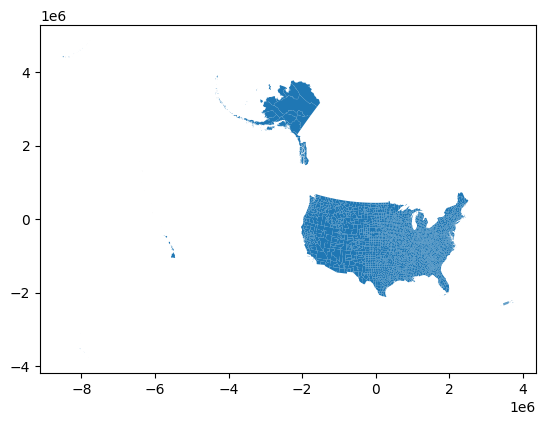

In [77]:
#Change crs and plot
df_county = df_county.to_crs("EPSG:9311")
df_county.plot()

### **3.1.6 Merge df_combined_county with geospatial county dataset**

In [78]:
# Add FIPS Code column to df_combined for easy merging with geospatial dataset
df_combined_county['FIPS'] = df_combined_county['CountyId'].astype(str).str.zfill(5)

df_combined_county.head(2)

State    County  CountyId  Residential Solar Potential (TWh - 2020)  \
0  Georgia   Appling     13001                                  0.030687   
1  Georgia  Atkinson     13003                                  0.014417   

   Energy Burden (% of Income)  Population  Hispanic  White  Black  Native  \
0                         4.70       18471       9.7   69.6   17.9     0.6   
1                         4.64        8313      24.6   56.6   17.8     0.7   

   Asian  Pacific  PerCapita Income (USD)  Poverty %   FIPS  
0    0.8      0.0                   19936       24.7  13001  
1    0.0      0.0                   19904       27.4  13003

In [79]:
# Check datatype for CountyId
df_combined_county['CountyId'].dtype

dtype('int64')

In [80]:
# Check to see if data type of GEOID in df_county matched
df_county['GEOID'].dtype

dtype('O')

In [81]:
# Convert CountyID from integer to string
df_combined_county['CountyId'] = df_combined_county['CountyId'].astype(str)

In [82]:
df_clean_county = pd.merge(df_county, df_combined_county, left_on='GEOID', right_on='CountyId', how='right')
df_clean_county.head()

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID      NAME LSAD  \
0      13      001  00349113  0500000US13001  13001   Appling   06   
1      13      003  00345784  0500000US13003  13003  Atkinson   06   
2      13      005  00344784  0500000US13005  13005     Bacon   06   
3      13      007  00342832  0500000US13007  13007     Baker   06   
4      13      009  00345255  0500000US13009  13009   Baldwin   06   

        ALAND    AWATER                                           geometry  \
0  1316423274  10328007  POLYGON ((1647046.395 -1301860.949, 1647347.29...   
1   887636792   4701677  POLYGON ((1598695.449 -1350473.788, 1598841.99...   
2   735776071   4500457  POLYGON ((1643425.774 -1323363.968, 1641424.93...   
3   885665383  18598654  POLYGON ((1459966.59 -1387565.194, 1460126.216...   
4   670027544  24802965  POLYGON ((1538631.28 -1161476.342, 1538792.511...   

   ... Population Hispanic White  Black  Native  Asian  Pacific  \
0  ...      18471      9.7  69.6   17.9     0.6    0.8      0.0   
1  ...       8313     24.6  56.6   17.8     0.7    0.0      0.0   
2  ...      11279      8.5  73.6   14.6     0.0    0.9      0.2   
3  ...       3251      5.4  52.1   41.3     0.2    0.6      0.5   
4  ...      45527      2.2  52.9   41.4     0.3    1.5      0.2   

   PerCapita Income (USD)  Poverty %   FIPS  
0                   19936       24.7  13001  
1                   19904       27.4  13003  
2                   18856       23.2  13005  
3                   22270       19.5  13007  
4                   20114       27.8  13009  

[5 rows x 25 columns]

In [83]:
# Check df_clean_county shape
df_clean_county.shape

(489, 25)

## **3.2 Analysis**

### **3.2.1 Perform Clustering Analysis**

The following links were helpful references for the analysis:

*  [Real Python Guide](https://realpython.com/k-means-clustering-python/)
*  [Data Camp](https://www.datacamp.com/tutorial/k-means-clustering-python)
*  [Domino](https://domino.ai/blog/getting-started-with-k-means-clustering-in-python)


<br>


**Tasks:**
*  Select key variables for clustering
*  Standardize features
*  Find optimal classes using the elbow method
*  Run final K-means clustering
*  Assign Cluster labels to counties

<br>




*  *Select key variables for clustering*



In [84]:
# Create BIPOC Column in df_clean_county
df_clean_county['BIPOC %'] = df_clean_county['Hispanic'] + df_clean_county['Black'] + df_clean_county['Native'] + df_clean_county['Asian'] + df_clean_county['Pacific']

df_clean_county.head()

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID      NAME LSAD  \
0      13      001  00349113  0500000US13001  13001   Appling   06   
1      13      003  00345784  0500000US13003  13003  Atkinson   06   
2      13      005  00344784  0500000US13005  13005     Bacon   06   
3      13      007  00342832  0500000US13007  13007     Baker   06   
4      13      009  00345255  0500000US13009  13009   Baldwin   06   

        ALAND    AWATER                                           geometry  \
0  1316423274  10328007  POLYGON ((1647046.395 -1301860.949, 1647347.29...   
1   887636792   4701677  POLYGON ((1598695.449 -1350473.788, 1598841.99...   
2   735776071   4500457  POLYGON ((1643425.774 -1323363.968, 1641424.93...   
3   885665383  18598654  POLYGON ((1459966.59 -1387565.194, 1460126.216...   
4   670027544  24802965  POLYGON ((1538631.28 -1161476.342, 1538792.511...   

   ... Hispanic White Black  Native  Asian  Pacific  PerCapita Income (USD)  \
0  ...      9.7  69.6  17.9     0.6    0.8      0.0                   19936   
1  ...     24.6  56.6  17.8     0.7    0.0      0.0                   19904   
2  ...      8.5  73.6  14.6     0.0    0.9      0.2                   18856   
3  ...      5.4  52.1  41.3     0.2    0.6      0.5                   22270   
4  ...      2.2  52.9  41.4     0.3    1.5      0.2                   20114   

   Poverty %   FIPS  BIPOC %  
0       24.7  13001     29.0  
1       27.4  13003     43.1  
2       23.2  13005     24.2  
3       19.5  13007     48.0  
4       27.8  13009     45.6  

[5 rows x 26 columns]

In [85]:
# Select key variables for clustering
features = ['Residential Solar Potential (TWh - 2020)', 'Energy Burden (% of Income)', 'BIPOC %',
            'Poverty %', 'PerCapita Income (USD)']

X = df_clean_county[features]




*   *Standardize features*




In [86]:
# Standardize features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

***We experimented with modest manual weighting of energy burden and socioeconomic factors after standardization to emphasize equity in the clustering. However, the original clustering without weighting provided clearer separation between counties facing affordability and racial equity challenges versus those with strong solar opportunity.***

In [87]:
# Convert back to DataFrame for easier manipulation
# X_scaled = pd.DataFrame(X_scaled, columns=features)

# Manual rescaling for emphasis
# X_scaled['Energy Burden (% of Income)'] *= 2
# X_scaled['Poverty %'] *= 1.5
# X_scaled['BIPOC %'] *= 1.5



*   *Find optimal classes using the elbow method*



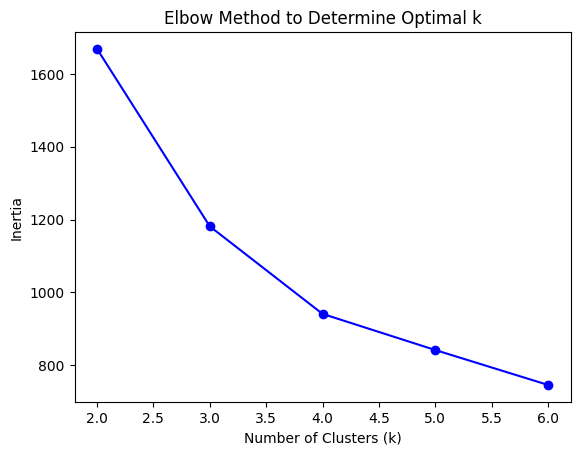

In [88]:
inertia = []
k_range = range(2, 7)  # Try between 2 and 7 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

***To decide on the number of clusters for the county-level analysis, we used the Elbow Method. This approach looks at how inertia — the total distance between counties and their assigned cluster centers — changes as more clusters are added.***

***The graph shows that inertia drops sharply between 2 and 3 clusters, and while there is still a decrease from 3 to 4, the improvement after 3 becomes much less significant. After 4, the line flattens out even more.***

***Based on this pattern, we selected k=3 as the final number of clusters. This choice keeps the analysis simple while still capturing meaningful differences between counties in terms of energy burden, solar potential, and socioeconomic factors.***
<br>




*   *Run final K-means clustering and Assign Cluster labels to counties*




In [89]:
# Perform k-means using k= 3
kmeans = KMeans(n_clusters=3, random_state=42)

# Assign cluster labels to counties
df_clean_county['Cluster'] = kmeans.fit_predict(X_scaled)

# Check
df_clean_county[['County', 'State', 'Cluster']].head()


County    State  Cluster
0   Appling  Georgia        2
1  Atkinson  Georgia        2
2     Bacon  Georgia        2
3     Baker  Georgia        2
4   Baldwin  Georgia        2

In [90]:
# Check Clusters and their counts
df_clean_county.Cluster.value_counts()

Cluster
0    282
1    105
2    102
Name: count, dtype: int64

***Currently, Clusters 0, 1, and 2 are just labels — The model itself does not show what "high burden" or "high solar potential" is. We interpret the meaning of each cluster based on their feature averages.***

In [91]:
# Group by cluster and calculate the mean for each feature
cluster_profiles = df_clean_county.groupby('Cluster')[
    ['Residential Solar Potential (TWh - 2020)', 'Energy Burden (% of Income)', 'BIPOC %',
            'Poverty %', 'PerCapita Income (USD)']
].mean().reset_index()

cluster_profiles


Cluster  Residential Solar Potential (TWh - 2020)  \
0        0                                  0.104399   
1        1                                  0.588011   
2        2                                  0.057708   

   Energy Burden (% of Income)    BIPOC %  Poverty %  PerCapita Income (USD)  
0                     4.531738   7.379433  14.805319            24526.265957  
1                     2.872857  20.096190  12.070476            31515.800000  
2                     5.049020  43.023529  25.254902            19584.686275

Following the clustering analysis, three distinct groups of counties emerged based on energy burden, solar potential, racial demographics, and income characteristics:

*   **Cluster 0** ***(Priority 2)*** includes counties with moderate energy burden (4.5%), relatively low BIPOC populations (7.4%), and moderate poverty rates (14.8%). These counties also have moderate residential solar potential (0.10 TWh).

*   **Cluster 1** ***(Priority 3)*** captures counties with the highest solar potential (0.59 TWh) and the lowest energy burden (2.87%). Although the BIPOC percentage is somewhat higher (20%), poverty rates remain lower (12%) and incomes are relatively higher ($31,516). These counties represent strong technical opportunity with moderate equity concerns.

*   **Cluster 2** ***(Priority 1)*** groups together counties facing the greatest affordability and equity challenges. These counties have the highest energy burden (5.05%), the highest BIPOC percentages (43%), the highest poverty rates (25%), and the lowest per capita incomes ($19,585). Solar potential here is lower (0.058 TWh) but still meaningful.

In [92]:
# Assign Classes to the clusters
df_clean_county['Cluster Class'] = np.where(
    df_clean_county['Cluster'] == 2, 'Priority 1',
    np.where(
        df_clean_county['Cluster'] == 0, 'Priority 2',
        'Priority 3'
    )
)


df_clean_county.tail()

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID          NAME LSAD  \
484      42      125  01209190  0500000US42125  42125    Washington   06   
485      42      127  01213692  0500000US42127  42127         Wayne   06   
486      42      129  01209191  0500000US42129  42129  Westmoreland   06   
487      42      131  01209192  0500000US42131  42131       Wyoming   06   
488      42      133  01209193  0500000US42133  42133          York   06   

          ALAND    AWATER                                           geometry  \
484  2219590657  10147675  POLYGON ((1642860.922 -364968.438, 1642838.039...   
485  1879248516  64833220  POLYGON ((2011748.469 -115108.551, 2011753.693...   
486  2662611738  20838920  POLYGON ((1688470.659 -331554.809, 1688415.595...   
487  1029016037  20034373  POLYGON ((1945753.138 -118548.946, 1945898.599...   
488  2341882851  16941832  POLYGON ((1916469.782 -279947.448, 1919895.712...   

     ... Black Native Asian  Pacific  PerCapita Income (USD)  Poverty %  \
484  ...   2.9    0.1   0.9      0.0                   32828        9.7   
485  ...   3.1    0.2   0.6      0.0                   25569       11.1   
486  ...   2.3    0.0   0.9      0.0                   31827       10.3   
487  ...   0.7    0.1   0.4      0.0                   28046       10.4   
488  ...   5.2    0.1   1.4      0.0                   30178       10.3   

      FIPS  BIPOC %  Cluster  Cluster Class  
484  42125      5.5        1     Priority 3  
485  42127      8.1        0     Priority 2  
486  42129      4.3        1     Priority 3  
487  42131      3.0        0     Priority 2  
488  42133     13.6        1     Priority 3  

[5 rows x 28 columns]

In [93]:
# Value counts of Priority Classes by State
priority_counts = df_clean_county.groupby(['State', 'Cluster Class']).size() \
    .unstack(fill_value=0) \
    .reset_index()

priority_counts


Cluster Class         State  Priority 1  Priority 2  Priority 3
0                   Georgia          97          38          24
1                   Indiana           0          75          17
2                  Michigan           2          63          18
3                      Ohio           1          63          24
4              Pennsylvania           2          43          22

### **3.2.2 Spatial Autocorrelation Analysis**

### **3.2.1 Perform Clustering Analysis**

The following links were helpful references for the analysis:

*  [Exploratory Spatial Data Analysis in Python](https://darribas.org/gds_scipy16/ipynb_md/04_esda.html)
*  [Introduction to Spatial Autocorrelation (Moran’s I)](https://darribas.org/gds19/content/labs/lab_06.html)
*  [ GeoDa Center - Contiguity Weights](https://geodacenter.github.io/workbook/4a_contig_weights/lab4a.html)




<br>


**Tasks:**
*  Define neighboring counties using Queen Contiguity weights
*  Calculate Moran’s I statistic
*  Visualize results using Moran’s I scatterplot


<br>



*   *Define neighboring counties*

***We use a Queen Contiguity weights matrix to define neighboring counties for the Moran’s I analysis. Counties that share either a border or a point are considered neighbors, which helps capture more spatial relationships — especially important given the irregular shapes of U.S. counties.***


In [94]:
df_auto = df_clean_county.copy()

w = libpysal.weights.Queen.from_dataframe(df_auto, use_index=True)
w.transform = 'r'


/usr/local/lib/python3.11/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.




*   *Calculate Moran’s I statistic*

***Moran’s I tests whether similar values are clustered together or randomly scattered across space. Positive values mean clustering, values near zero mean no clear pattern, and negative values mean opposite values are near each other***


In [95]:
# Select Cluster column from the cluster analysis for this step
y = df_auto['Cluster']


# Calculate Moran's I
moran = esda.Moran(y, w)

# Print Moran's I and p-value
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")


Moran's I: 0.6219484623475586
P-value: 0.001


*   *Visualize Results*

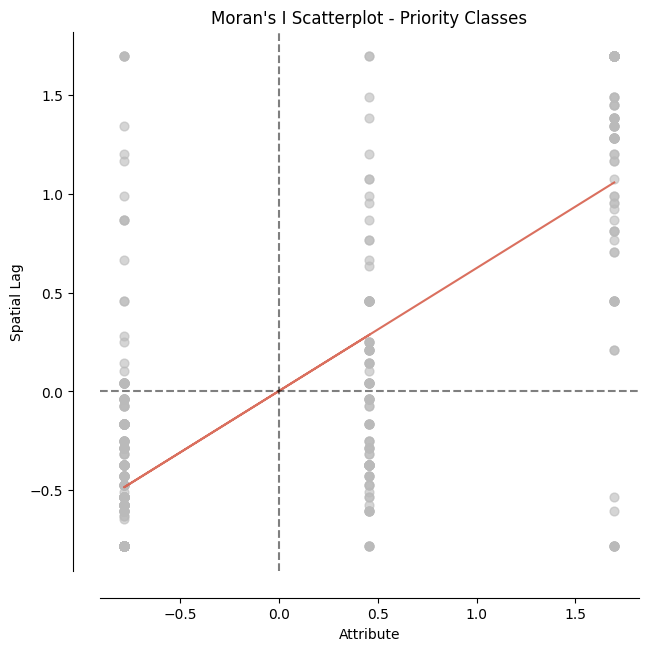

In [96]:
# Correct Moran scatterplot code
esdaplot.moran_scatterplot(moran, aspect_equal=True)
plt.title("Moran's I Scatterplot - Priority Classes")
plt.show()

***Moran’s I for Priority Class was 0.62, significant at the 5% level (p = 0.001), indicating a strong and statistically significant spatial clustering of counties with similar energy burden, solar potential, and socioeconomic characteristics.?***

***The Moran scatterplot shows standardized Priority Class values on the x-axis and the average class of neighboring counties on the y-axis. Each point represents one county, and the dashed lines at zero divide the plot into four quadrants. The red trend line has a strong positive slope, meaning counties with the same Priority Class — like Priority 1 (high need) or Priority 3 (opportunity) — tend to be located near each other rather than randomly scattered.***

***Because Priority Class is a discrete variable (0, 1, 2), the scatterplot shows three main vertical groupings instead of a continuous cloud. If we had tested a continuous variable like Energy Burden directly, the points would be more spread out, and the clustering would likely be less sharp.***

***Overall, the strong Moran’s I value and pattern in the plot support the idea that counties facing similar energy equity conditions are geographically concentrated, reinforcing the case for regional targeting in clean energy interventions.***

<br>


## **3.3 Plots**


*  Visualize County Cluster Classes in Selected States
*  Visualize County Cluster Classes in Selected States on the US Map



### **3.3.1 Map of County Cluster Classes in Selected States**

In [97]:
# Create dataframe for only the 5 states for the basemap
df_5states = df_clean[df_clean['State Name'].isin(selected_states)]
df_5states.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS          NAME LSAD  \
6       26  01779789  0400000US26    26     MI      Michigan   00   
17      13  01705317  0400000US13    13     GA       Georgia   00   
18      42  01779798  0400000US42    42     PA  Pennsylvania   00   
41      39  01085497  0400000US39    39     OH          Ohio   00   
46      18  00448508  0400000US18    18     IN       Indiana   00   

           ALAND        AWATER  \
6   146600952990  103885855702   
17  149482048342    4422936154   
18  115884442321    3394589990   
41  105828882568   10268850702   
46   92789302676    1538002829   

                                             geometry  ...  \
6   MULTIPOLYGON (((1376542.504 -187676.574, 13766...  ...   
17  MULTIPOLYGON (((1774018.899 -1324581.179, 1774...  ...   
18  POLYGON ((1619177.315 -262060.235, 1618879.478...  ...   
41  MULTIPOLYGON (((1422967.707 -227158.235, 14230...  ...   
46  POLYGON ((1041911.852 -714123.548, 1042168.307...  ...   

   Residential Solar Potential (TWh - 2020)  Energy Burden     Region  \
6                                 19.931620           4.21    Midwest   
17                                18.698911           3.88      South   
18                                19.582856           3.82  Northeast   
41                                23.521982           3.69    Midwest   
46                                15.332584           3.72    Midwest   

   Land Area (sq mi)  Solar_per_sq_mile  Solar Potential Class  \
6       56602.684552           0.000352         High Potential   
17      57715.076580           0.000324         High Potential   
18      44743.027923           0.000438         High Potential   
41      40860.572420           0.000576         High Potential   
46      35825.985589           0.000428         High Potential   

   Energy Burden Class                      Quadrant             x  \
6          High Burden  High Potential / High Burden  1.154939e+06   
17         High Burden  High Potential / High Burden  1.547877e+06   
18         High Burden  High Potential / High Burden  1.839454e+06   
41         High Burden  High Potential / High Burden  1.447386e+06   
46         High Burden  High Potential / High Burden  1.164707e+06   

               y  
6   2.873104e+04  
17 -1.221111e+06  
18 -2.075492e+05  
41 -3.721782e+05  
46 -4.706559e+05  

[5 rows x 21 columns]

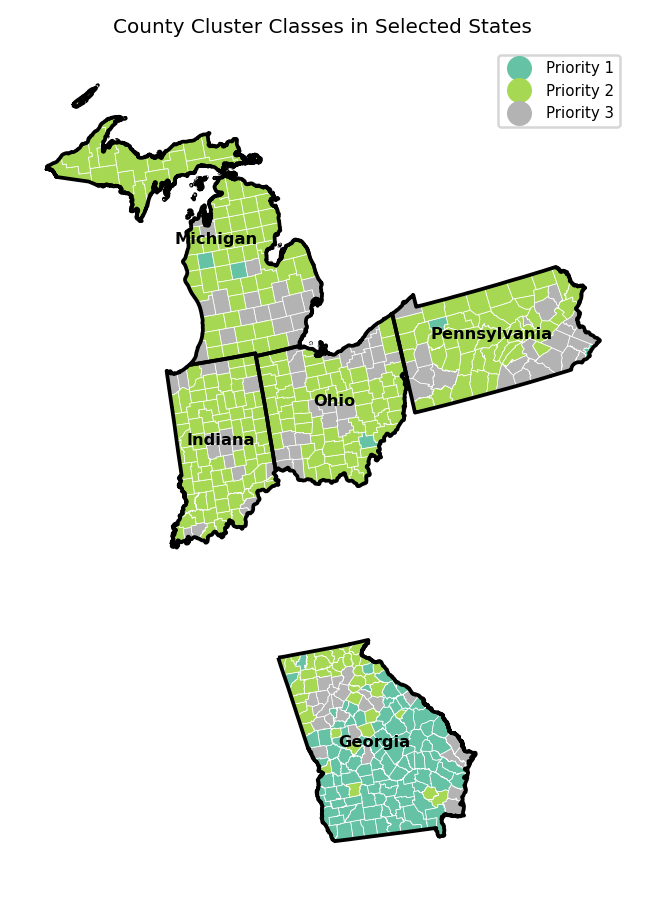

In [98]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=180)

# 1. Plot 5 state outlines
df_5states.boundary.plot(
    ax=ax,
    edgecolor='black',
    linewidth=1.5
)

# 2. Plot selected counties colored by Cluster Class
df_clean_county.plot(
    ax=ax,
    column='Cluster Class',
    cmap='Set2',
    linewidth=0.3,
    edgecolor='white',
    legend=True,
    legend_kwds={'fontsize': 6, 'title_fontsize': 6}
)

# 3. Add state names at their centroids
for idx, row in df_5states.iterrows():
    name = row['NAME']
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y

    plt.text(
        x, y,
        name,
        horizontalalignment='center',
        fontsize=6.5,
        color='black',
        weight='bold'
    )


ax.set_title('County Cluster Classes in Selected States', fontsize=8)
ax.axis('off')


plt.show()

### **3.3.2 County Cluster Classes in Selected States on the US Map**

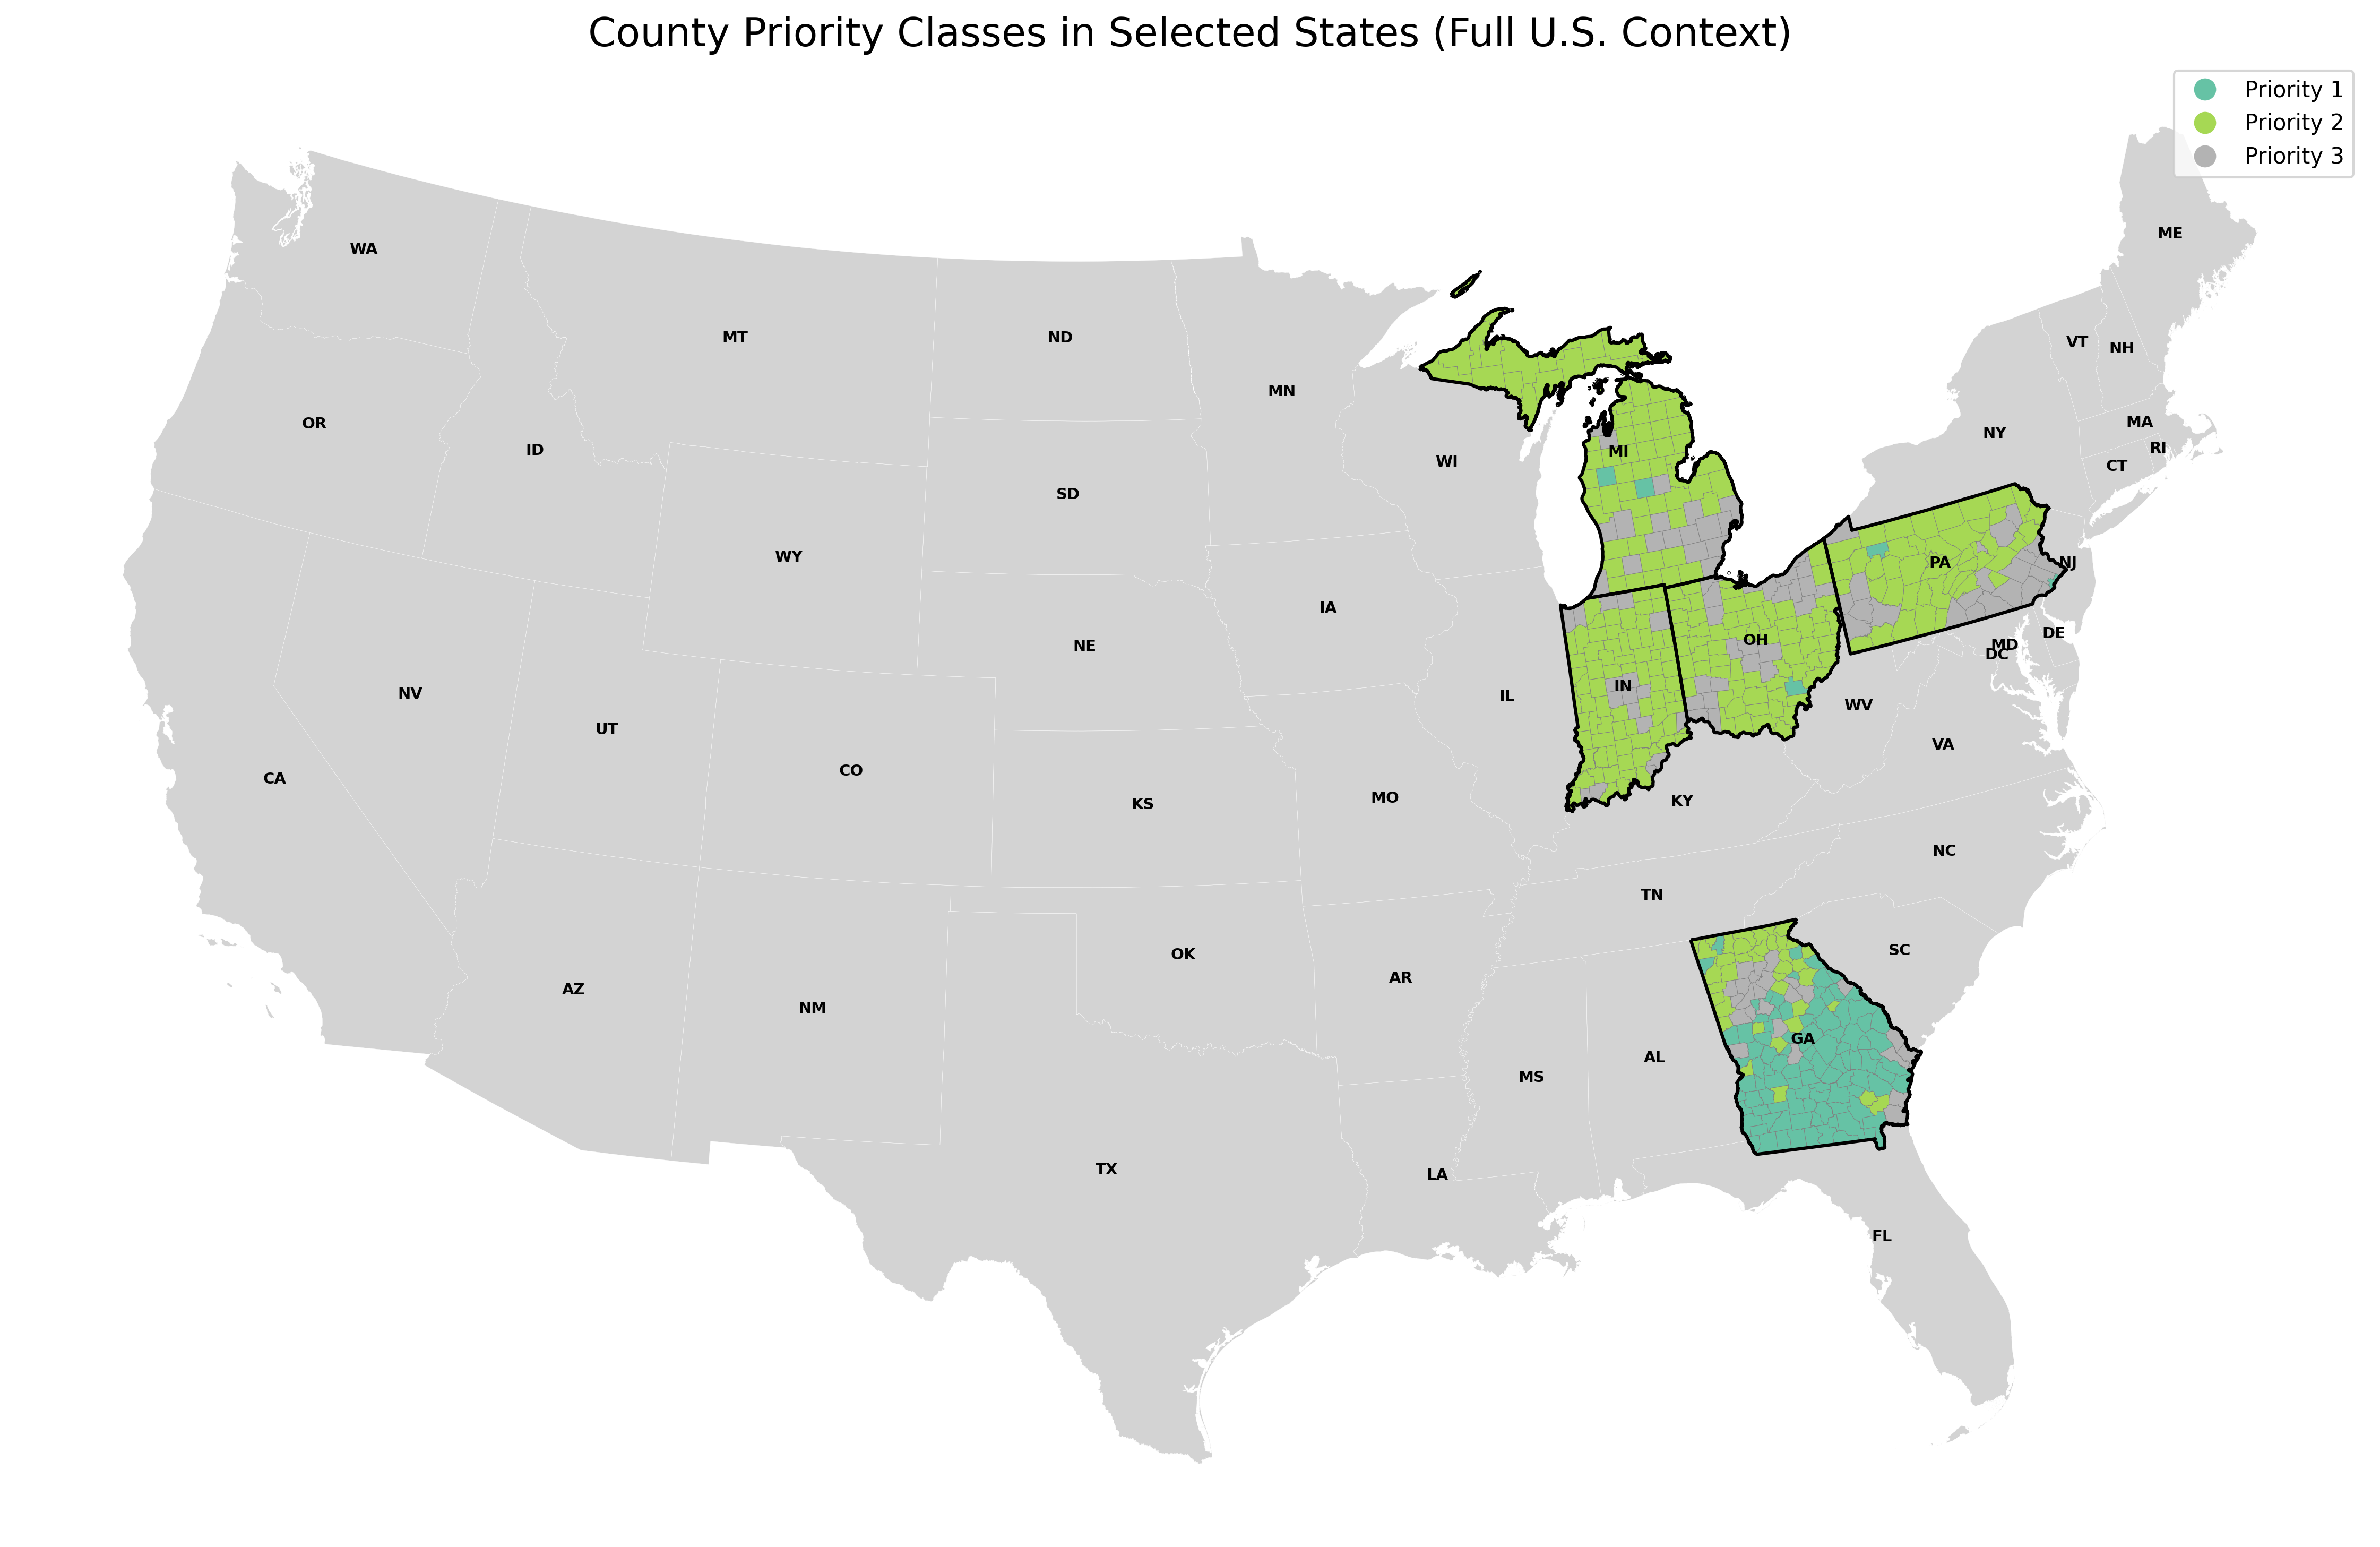

In [99]:
fig, ax = plt.subplots(figsize=(20, 12), dpi=300)

# 1. Plot all U.S. counties in light gray
df_clean.plot(
    ax=ax,
    color='lightgray',
    linewidth=0.1,
    edgecolor='white'
)

# 2. Plot 5 state outlines
df_5states.boundary.plot(
    ax=ax,
    edgecolor='black',
    linewidth=1.5
)

# 3. Overlay selected counties
df_clean_county.plot(
    ax=ax,
    column='Cluster Class',
    cmap='Set2',
    linewidth=0.2,
    edgecolor='gray',
    legend=True
)


ax.set_title('County Priority Classes in Selected States (Full U.S. Context)', fontsize=18)
ax.axis('off')


# 3. Add state names at centroids
for idx, row in df_clean.iterrows():
    plt.text(
        row.geometry.centroid.x,
        row.geometry.centroid.y,
        row['STUSPS'],
        horizontalalignment='center',
        fontsize=7,
        color='black',
        weight='bold'
    )

plt.show()

* **Priority 1** counties, representing the highest need (high burden, low income, high poverty), are **strongly concentrated in Georgia**.
*  **Priority 2** counties, showing moderate opportunity and need, **dominate much of Michigan, Ohio, Indiana, and Pennsylvania**.
*  **Priority 3 counties**, representing the strongest opportunities (higher incomes, lower burden), are scattered but **visible across all five states, especially in the Midwest and Northeast**.

<br>



# **4. Conclusion**

This project explored how energy burden, solar potential, and socioeconomic characteristics intersect at the county level across selected high-priority states.
By clustering counties based on these factors and testing for spatial autocorrelation, we uncovered patterns that can help guide more equitable clean energy investments.

<br>

The key takeaways are:


1.   **Energy Equity Remains a Central Challenge:**

  Even among the "Priority 3: Opportunity Counties" which are the best positioned in terms of solar potential and relatively lower burden,  average per capita incomes fall well below the U.S. median of $42,220 (*U.S Census Bureau, https://fred.stlouisfed.org/series/MEPAINUSA672N*).
  This highlights that underlying economic vulnerability persists, even where technical feasibility is strong.

2. **Strong concentration of high burden, high poverty and low income in Georgia**
  
  Rural Georgia typically has older infrastructure and less energy efficient buildings which may affect energy costs. Future research could explore if the clusters highlighted here align with redlining areas.

3. **Spatial Patterns Matter:**
  
  The Moran’s I analysis confirmed that counties with similar opportunity and need profiles tend to cluster geographically.
  This reinforces the value of regional strategies; interventions may be more impactful when targeted to clusters of high-need counties, rather than isolated communities.

4.  **Opportunity and Need Overlap:**

  The counties identified are not simply high in solar potential or burden in isolation.
  Many counties stand at the intersection of high opportunity and high need. These are exactly the type of areas where clean energy investments could deliver the greatest social and environmental impact.
  
5. **Beyond State Averages:**

  The county-level analysis reveals inequalities and opportunities that state averages can mask.
  In particular, Georgia’s strong showing of Priority 1 counties highlights why zooming into finer scales is critical for equitable policymaking.